# Prática 04 - Regressão

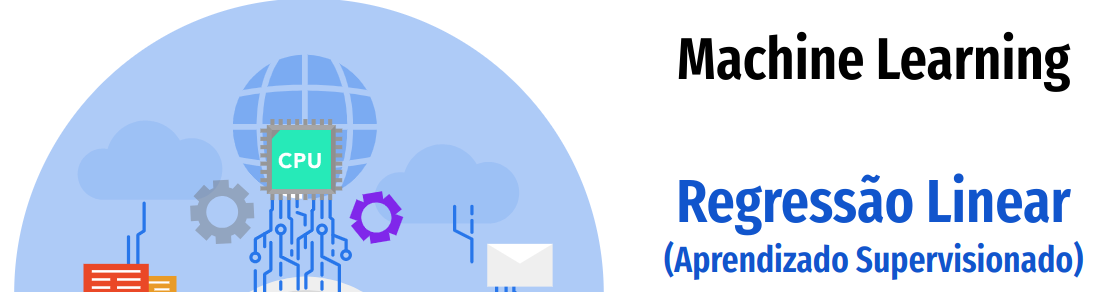

**Pessoa estudante**:  
- José Vitor Velozo de Carvalho (jvvc@cesar.school)
- Matheus Pereira do Rego Barros (mprb@cesar.school)

**Objetivo da Prática**


O objetivo desta prática é tentar predizer o valor da taxa pré-fixada relacionada ao título Tesouro IPCA 2024. O motivação desta previsão é tentar sempre tomar uma boa decisão de investimento.


**Instruções para a prática.**

1. Criar um dataset com informações macroeconômicas.

2. Realizar experimentos de regressão como indicado ao longo do notebook. Observe que o mesmo possui dicas espalhadas do que pode ser feito. Não necessariamente você precisa seguir 100% estas dicas.

3. **Submeter no Classroom até a data limite. Após o prazo limite, punição de -25 pontos por dia de atraso.**

4. Sugiro olhar o tópico de referências para usar as bibliotecas sugeridas para importar dados macroeconômicos.



In [1]:
START_DATE = '2014-01-02'
END_DATE = '2024-04-16'
YF_END_DATE = '2024-04-17'

DIRECTORY = "./datasets/ntn_b_principal"
anos = [2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022, 2023, 2024]

In [2]:
# Não apagar. recomendo usar essa lib para pegar os dados da SELIC e IPCA!
! pip install great_tables
! pip install python-bcb
! pip install yfinance
! pip install ipeadatapy
! pip install statsmodels
! pip install scikit-learn
! pip install xgboost
! pip install scikeras
! pip install pmdarima

In [3]:
# Imports!
import matplotlib.dates as mdates
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import pmdarima as pm
import seaborn as sns
import yfinance as yf
from bcb import currency, Expectativas, sgs, TaxaJuros
from great_tables import GT
from collections import Counter
from prophet import Prophet
from scipy.signal import periodogram
from scipy.stats import ks_2samp, mstats
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import make_scorer, mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import GridSearchCV, train_test_split, TimeSeriesSplit, ParameterGrid
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller


c:\Users\Vitor\notebooks\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
# Paleta de cores
colors = {
    "blue": "#2074b4",
    "gray": "#999999",
    "orange": "#ff7f0e",
    "red": "#d62728",
    "purple": "#8a2be2",
}

## Parte 1 - Importação e Criação de dataset com dados macroeconômicos

Quais são os fatores que influenciam nas taxas dos títulos públicos? Claramente o dolar é um deles, mas note que é um fator externo. Lembre de incluir na sua análise os seguintes parâmetros:

- Taxa de Juros Brasileira (SELIC)
- Índice de inflação (IPCA) e/ou Expectativa do IPCA
- Valor do título do tesouro (NTN-B 2024).

O objetivo da prática é predizer o a coluna 'Taxa Compra Manhã'. Note que esta taxa está em porcentagem. Ao longo do código eu sugiro converter para número, fazendo a multiplicação por 100.

**Pontuação: 40 Pontos**

### Importação dos dados "NTN-B 2024"

NTN-B é o nome que se dá ao título do Tesouro Direto que é indexado à inflação. Justamente por ser indexado à inflação é que este título também é conhecido como Tesouro IPCA +. Na prática, NTN-B significa Nota do Tesouro Nacional série B. NTN-B e NTN-B Principal são apenas dois de vários títulos da dívida pública negociados no Tesouro Direto.

1. Acesse o site https://www.tesourodireto.com.br/titulos/historico-de-precos-e-taxas.htm

2. Baixe os arquivos históricos do título NTN-B 2024 de 2014 até 2024. Salve cada arquivo como (NTN-B_Principal_20xx.xls).

In [5]:
def create_ntnb_df() -> pd.DataFrame:
    dfs = []

    for filename in os.listdir(DIRECTORY):
        if filename.endswith(".xls"):
            file_path = os.path.join(DIRECTORY, filename)
            df = pd.read_excel(file_path, sheet_name="NTN-B Princ 150824", header=1)
            dfs.append(df)

    return pd.concat(dfs, ignore_index=True)

In [6]:
df = create_ntnb_df()

Em primeiro momento, vamos ajustar os dados para estarem dentro do formato esperado e na data esperada.

In [7]:
def adjust_ntnb_format(dfi: pd.DataFrame) -> pd.DataFrame:
  # Ajustar a taxa, está em %, vamos colocar em x.xx
  dfi['Taxa Compra Manhã'] = 100*dfi['Taxa Compra Manhã']
  dfi['Taxa Venda Manhã'] = 100*dfi['Taxa Venda Manhã']
  return dfi

In [8]:
df = adjust_ntnb_format(df)

In [9]:
def trim_df_by_date(dfi: pd.DataFrame) -> pd.DataFrame:
    dfi['Dia'] = pd.to_datetime(dfi['Dia'], dayfirst=True)
    dfi = dfi.loc[(dfi['Dia'] >= START_DATE) & (dfi['Dia'] <= END_DATE)]
    return dfi

In [10]:
df = trim_df_by_date(df)

In [11]:
df.head()

Dia  Taxa Compra Manhã  Taxa Venda Manhã  PU Compra Manhã  \
0 2014-01-02               6.43              6.51          1217.75   
1 2014-01-03               6.47              6.55          1214.18   
2 2014-01-06               6.47              6.55          1214.80   
3 2014-01-07               6.48              6.56          1214.22   
4 2014-01-08               6.46              6.54          1217.26   

   PU Venda Manhã  PU Base Manhã  
0         1208.11        1207.49  
1         1204.58        1203.33  
2         1205.20        1204.58  
3         1204.63        1204.01  
4         1207.64        1207.02

In [12]:
df.tail()

Dia  Taxa Compra Manhã  Taxa Venda Manhã  PU Compra Manhã  \
2558 2024-04-10               7.44              7.56          4148.19   
2559 2024-04-11               7.53              7.65          4148.39   
2560 2024-04-12               7.60              7.72          4149.30   
2561 2024-04-15               7.48              7.60          4152.55   
2562 2024-04-16               7.51              7.63          4153.84   

      PU Venda Manhã  PU Base Manhã  
2558         4145.16        4145.16  
2559         4145.36        4145.36  
2560         4145.86        4145.86  
2561         4149.30        4149.30  
2562         4150.60        4150.60

In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2563 entries, 0 to 2562
Data columns (total 6 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   Dia                2563 non-null   datetime64[ns]
 1   Taxa Compra Manhã  2563 non-null   float64       
 2   Taxa Venda Manhã   2563 non-null   float64       
 3   PU Compra Manhã    2563 non-null   float64       
 4   PU Venda Manhã     2563 non-null   float64       
 5   PU Base Manhã      2563 non-null   float64       
dtypes: datetime64[ns](1), float64(5)
memory usage: 140.2 KB


In [14]:
df.describe()

Dia  Taxa Compra Manhã  Taxa Venda Manhã  \
count                           2563        2563.000000       2563.000000   
mean   2019-02-19 14:29:10.136558592           5.158307          5.262645   
min              2014-01-02 00:00:00           1.200000          1.320000   
25%              2016-07-20 12:00:00           4.210000          4.330000   
50%              2019-02-20 00:00:00           5.630000          5.740000   
75%              2021-09-18 12:00:00           6.360000          6.440000   
max              2024-04-16 00:00:00           7.970000          8.090000   
std                              NaN           1.651135          1.639582   

       PU Compra Manhã  PU Venda Manhã  PU Base Manhã  
count      2563.000000     2563.000000    2563.000000  
mean       2570.257448     2558.731420    2558.084175  
min        1161.240000     1152.160000    1151.130000  
25%        1819.595000     1811.355000    1810.435000  
50%        2542.270000     2526.430000    2525.060000  
75%        3237.225000     3225.365000    3223.930000  
max        4153.840000     4150.600000    4150.600000  
std         854.780280      855.140675     855.367850

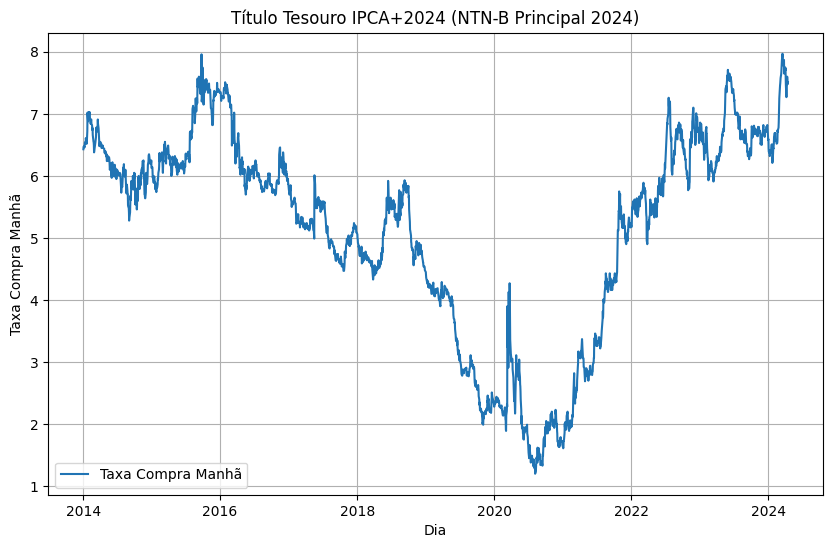

In [15]:
plt.figure(figsize=(10, 6))
plt.plot(df['Dia'], df['Taxa Compra Manhã'], color=colors['blue'], label='Taxa Compra Manhã')
plt.title('Título Tesouro IPCA+2024 (NTN-B Principal 2024)')
plt.xlabel('Dia')
plt.ylabel('Taxa Compra Manhã')
plt.grid(True)
plt.legend()
plt.show()

In [16]:
col1 = df.filter(items=['Dia', 'Taxa Compra Manhã', 'PU Compra Manhã'])

In [17]:
col1['Dia'] = pd.to_datetime(col1['Dia'], format='%d/%m/%Y')
col1.rename(columns={'Dia': 'Date'}, inplace=True)

In [18]:
col1.head(3)

Date  Taxa Compra Manhã  PU Compra Manhã
0 2014-01-02               6.43          1217.75
1 2014-01-03               6.47          1214.18
2 2014-01-06               6.47          1214.80

In [19]:
len(col1)

2563

In [20]:
ntnb = col1

### Moedas

Nas células abaixo, estaremos adicionando a coluna referente ao valor da conversão do dólar e do franco suíço.

CHF = Franco Suíço

USD = Dólar

In [21]:
currencies = ["CHF", "USD"]

In [22]:
moedas_df = currency.get(currencies, start=START_DATE, end=END_DATE)
moedas_df

CHF     USD
Date                      
2014-01-02  2.6603  2.3975
2014-01-03  2.6285  2.3741
2014-01-06  2.6301  2.3789
2014-01-07  2.6032  2.3634
2014-01-08  2.6142  2.3779
...            ...     ...
2024-04-10  5.5505  5.0654
2024-04-11  5.5749  5.0765
2024-04-12  5.6326  5.1364
2024-04-15  5.6640  5.1746
2024-04-16  5.7670  5.2635

[2581 rows x 2 columns]

In [23]:
moedas_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2581 entries, 2014-01-02 to 2024-04-16
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   CHF     2581 non-null   float64
 1   USD     2581 non-null   float64
dtypes: float64(2)
memory usage: 60.5 KB


In [24]:
moedas_df.describe()

CHF          USD
count  2581.000000  2581.000000
mean      4.328103     4.093108
std       1.168383     1.022467
min       2.397200     2.197400
25%       3.327700     3.243500
50%       3.967800     3.938600
75%       5.566000     5.102300
max       6.304900     5.937200

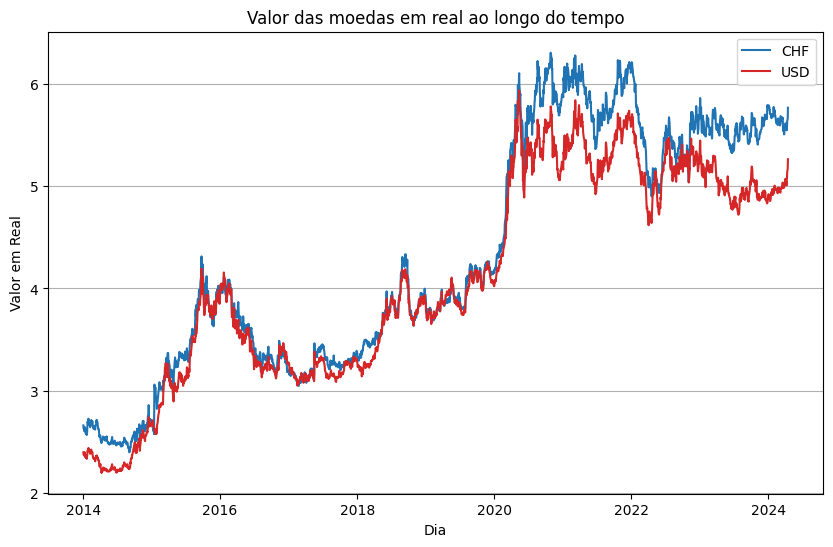

In [25]:
plt.figure(figsize=(10, 6))

plt.plot(moedas_df.index, moedas_df['CHF'], label='CHF', color=colors['blue'])
plt.plot(moedas_df.index, moedas_df['USD'], label='USD', color=colors['red'])

plt.title('Valor das moedas em real ao longo do tempo')
plt.xlabel('Dia')
plt.ylabel('Valor em Real')
plt.grid(axis='y')
plt.legend()
plt.show()

In [26]:
df = pd.merge(df, moedas_df, left_on='Dia', right_on="Date")
df

Dia  Taxa Compra Manhã  Taxa Venda Manhã  PU Compra Manhã  \
0    2014-01-02               6.43              6.51          1217.75   
1    2014-01-03               6.47              6.55          1214.18   
2    2014-01-06               6.47              6.55          1214.80   
3    2014-01-07               6.48              6.56          1214.22   
4    2014-01-08               6.46              6.54          1217.26   
...         ...                ...               ...              ...   
2558 2024-04-10               7.44              7.56          4148.19   
2559 2024-04-11               7.53              7.65          4148.39   
2560 2024-04-12               7.60              7.72          4149.30   
2561 2024-04-15               7.48              7.60          4152.55   
2562 2024-04-16               7.51              7.63          4153.84   

      PU Venda Manhã  PU Base Manhã     CHF     USD  
0            1208.11        1207.49  2.6603  2.3975  
1            1204.58        1203.33  2.6285  2.3741  
2            1205.20        1204.58  2.6301  2.3789  
3            1204.63        1204.01  2.6032  2.3634  
4            1207.64        1207.02  2.6142  2.3779  
...              ...            ...     ...     ...  
2558         4145.16        4145.16  5.5505  5.0654  
2559         4145.36        4145.36  5.5749  5.0765  
2560         4145.86        4145.86  5.6326  5.1364  
2561         4149.30        4149.30  5.6640  5.1746  
2562         4150.60        4150.60  5.7670  5.2635  

[2563 rows x 8 columns]

In [27]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2563 entries, 0 to 2562
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   Dia                2563 non-null   datetime64[ns]
 1   Taxa Compra Manhã  2563 non-null   float64       
 2   Taxa Venda Manhã   2563 non-null   float64       
 3   PU Compra Manhã    2563 non-null   float64       
 4   PU Venda Manhã     2563 non-null   float64       
 5   PU Base Manhã      2563 non-null   float64       
 6   CHF                2563 non-null   float64       
 7   USD                2563 non-null   float64       
dtypes: datetime64[ns](1), float64(7)
memory usage: 160.3 KB


### Ações de empresas brasileiras

Para complementar, incluiremos os valores das ações de empresas brasileiras como a Petrobrás e a Embraer, além dos valores de compra futura da soja (ZS=F) e do petróleo (CL=F).  Valores que consideramos relevantes a serem considerados para a formulação de previsões sobre a Taxa de Compra pela Manhã.

^BVSP = Bovespa

PBR = Petrobras

VALE = Vale

ERJ = Embraer

ZS=F = Compra futura da soja

CL=F = Compra futura do petróleo bruto

In [28]:
tickerSymbols = ['^BVSP', 'PBR', 'VALE', 'ERJ', 'ZS=F', 'CL=F']

In [29]:
tickerData = yf.download(tickerSymbols, period='1d', start=START_DATE, end=YF_END_DATE)
stock_df = tickerData['Close']
stock_df.index = pd.to_datetime(stock_df.index)

[*********************100%%**********************]  6 of 6 completed


In [30]:
stock_df

Ticker           CL=F        ERJ    PBR   VALE     ZS=F     ^BVSP
Date                                                             
2014-01-02  95.440002  32.130001  13.32  14.53  1287.00   50341.0
2014-01-03  93.959999  32.529999  13.12  14.33  1289.25   50981.0
2014-01-06  93.430000  32.250000  13.16  14.29  1296.75   50974.0
2014-01-07  93.669998  32.540001  12.90  14.04  1299.50   50430.0
2014-01-08  92.330002  32.520000  12.68  13.95  1300.75   50577.0
...               ...        ...    ...    ...      ...       ...
2024-04-10  86.209999  25.889999  16.16  12.15  1164.75  128054.0
2024-04-11  85.019997  25.590000  16.00  12.17  1159.25  127396.0
2024-04-12  85.660004  24.850000  15.72  12.02  1174.00  125946.0
2024-04-15  85.410004  24.150000  15.79  12.00  1158.25  125334.0
2024-04-16  85.360001  24.290001  15.65  11.67  1145.00  124389.0

[2653 rows x 6 columns]

In [31]:
stock_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2653 entries, 2014-01-02 to 2024-04-16
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   CL=F    2588 non-null   float64
 1   ERJ     2589 non-null   float64
 2   PBR     2589 non-null   float64
 3   VALE    2589 non-null   float64
 4   ZS=F    2587 non-null   float64
 5   ^BVSP   2549 non-null   float64
dtypes: float64(6)
memory usage: 145.1 KB


In [32]:
stock_df.describe()

Ticker         CL=F          ERJ          PBR         VALE         ZS=F  \
count   2588.000000  2589.000000  2589.000000  2589.000000  2587.000000   
mean      64.137550    19.964268    11.230475    11.896107  1128.288751   
std       20.291448     8.592489     3.433824     4.250427   249.917745   
min      -37.630001     4.110000     2.900000     2.150000   791.000000   
25%       48.805001    14.320000     8.820000     9.010000   913.750000   
50%       60.445000    19.230000    11.010000    12.680000  1021.500000   
75%       77.507498    25.190001    14.240000    14.120000  1359.625000   
max      123.699997    39.970001    20.650000    22.940001  1769.000000   

Ticker          ^BVSP  
count     2549.000000  
mean     85843.415065  
std      27084.583119  
min      37497.000000  
25%      57978.000000  
50%      87838.000000  
75%     110227.000000  
max     134194.000000

In [33]:
stock_df.index = pd.to_datetime(stock_df.index)

df = pd.merge(df, stock_df, left_on='Dia', right_on=stock_df.index, how='left')
df

Dia  Taxa Compra Manhã  Taxa Venda Manhã  PU Compra Manhã  \
0    2014-01-02               6.43              6.51          1217.75   
1    2014-01-03               6.47              6.55          1214.18   
2    2014-01-06               6.47              6.55          1214.80   
3    2014-01-07               6.48              6.56          1214.22   
4    2014-01-08               6.46              6.54          1217.26   
...         ...                ...               ...              ...   
2558 2024-04-10               7.44              7.56          4148.19   
2559 2024-04-11               7.53              7.65          4148.39   
2560 2024-04-12               7.60              7.72          4149.30   
2561 2024-04-15               7.48              7.60          4152.55   
2562 2024-04-16               7.51              7.63          4153.84   

      PU Venda Manhã  PU Base Manhã     CHF     USD       CL=F        ERJ  \
0            1208.11        1207.49  2.6603  2.3975  95.440002  32.130001   
1            1204.58        1203.33  2.6285  2.3741  93.959999  32.529999   
2            1205.20        1204.58  2.6301  2.3789  93.430000  32.250000   
3            1204.63        1204.01  2.6032  2.3634  93.669998  32.540001   
4            1207.64        1207.02  2.6142  2.3779  92.330002  32.520000   
...              ...            ...     ...     ...        ...        ...   
2558         4145.16        4145.16  5.5505  5.0654  86.209999  25.889999   
2559         4145.36        4145.36  5.5749  5.0765  85.019997  25.590000   
2560         4145.86        4145.86  5.6326  5.1364  85.660004  24.850000   
2561         4149.30        4149.30  5.6640  5.1746  85.410004  24.150000   
2562         4150.60        4150.60  5.7670  5.2635  85.360001  24.290001   

        PBR   VALE     ZS=F     ^BVSP  
0     13.32  14.53  1287.00   50341.0  
1     13.12  14.33  1289.25   50981.0  
2     13.16  14.29  1296.75   50974.0  
3     12.90  14.04  1299.50   50430.0  
4     12.68  13.95  1300.75   50577.0  
...     ...    ...      ...       ...  
2558  16.16  12.15  1164.75  128054.0  
2559  16.00  12.17  1159.25  127396.0  
2560  15.72  12.02  1174.00  125946.0  
2561  15.79  12.00  1158.25  125334.0  
2562  15.65  11.67  1145.00  124389.0  

[2563 rows x 14 columns]

Após percebermos uma quantidade de valores nulos para certas colunas, optamos por preencher estes valores com os últimos valores presentes, uma vez que estes valores geralmente não flutuam drasticamente de um dia para o outro.

In [34]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2563 entries, 0 to 2562
Data columns (total 14 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   Dia                2563 non-null   datetime64[ns]
 1   Taxa Compra Manhã  2563 non-null   float64       
 2   Taxa Venda Manhã   2563 non-null   float64       
 3   PU Compra Manhã    2563 non-null   float64       
 4   PU Venda Manhã     2563 non-null   float64       
 5   PU Base Manhã      2563 non-null   float64       
 6   CHF                2563 non-null   float64       
 7   USD                2563 non-null   float64       
 8   CL=F               2498 non-null   float64       
 9   ERJ                2499 non-null   float64       
 10  PBR                2499 non-null   float64       
 11  VALE               2499 non-null   float64       
 12  ZS=F               2497 non-null   float64       
 13  ^BVSP              2547 non-null   float64       
dtypes: datet

In [35]:
df.ffill(inplace=True)

In [36]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2563 entries, 0 to 2562
Data columns (total 14 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   Dia                2563 non-null   datetime64[ns]
 1   Taxa Compra Manhã  2563 non-null   float64       
 2   Taxa Venda Manhã   2563 non-null   float64       
 3   PU Compra Manhã    2563 non-null   float64       
 4   PU Venda Manhã     2563 non-null   float64       
 5   PU Base Manhã      2563 non-null   float64       
 6   CHF                2563 non-null   float64       
 7   USD                2563 non-null   float64       
 8   CL=F               2563 non-null   float64       
 9   ERJ                2563 non-null   float64       
 10  PBR                2563 non-null   float64       
 11  VALE               2563 non-null   float64       
 12  ZS=F               2563 non-null   float64       
 13  ^BVSP              2563 non-null   float64       
dtypes: datet

### Observando correlações

Ao observar os valores das correlaçõos para com PU Compra Manhã, que será o nosso rótulo, é possível perceber fortes correlaões com o dólar, o franco suíço, a BOVESPA, que no caso é a maior correlação, bem como correlações fortes com a Embraer e a VALE.

In [37]:
def plot_corr_heatmap(df: pd.DataFrame) -> None:
    plt.figure(figsize=(12, 10))
    sns.heatmap(df.corr(), annot=True, cmap='coolwarm', fmt=".2f")
    plt.title('Mapa de calor de correlações')
    plt.show()

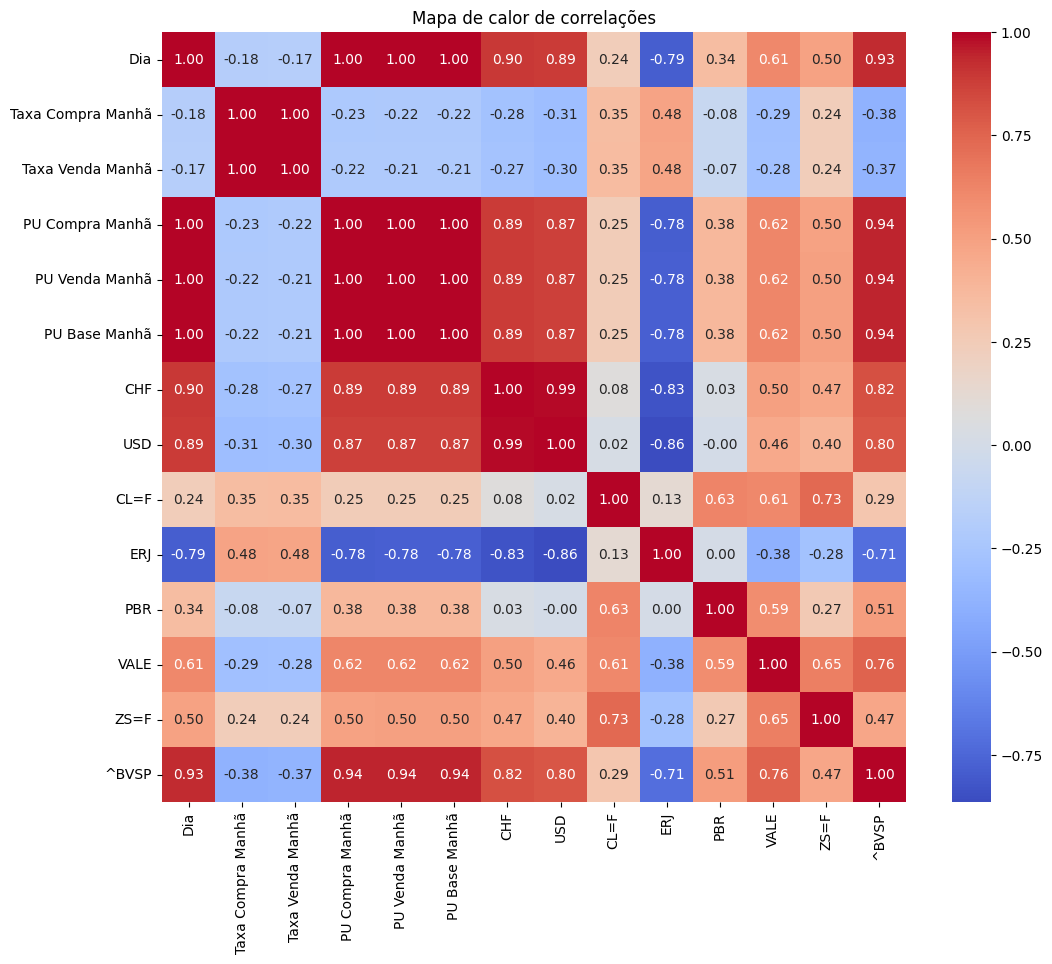

In [38]:
plot_corr_heatmap(df)

### SELIC

O SELIC é a taxa básica de juros da economia brasileira, estabelecida pelo Banco Central do Brasil. Ele é utilizado como referência para diversas operações financeiras no país. Quando o SELIC aumenta, os juros pagos pelos títulos públicos também tendem a subir, e vice-versa. Dessa forma, é muito importante que seja incluído nesta análise.

In [39]:
em = TaxaJuros()

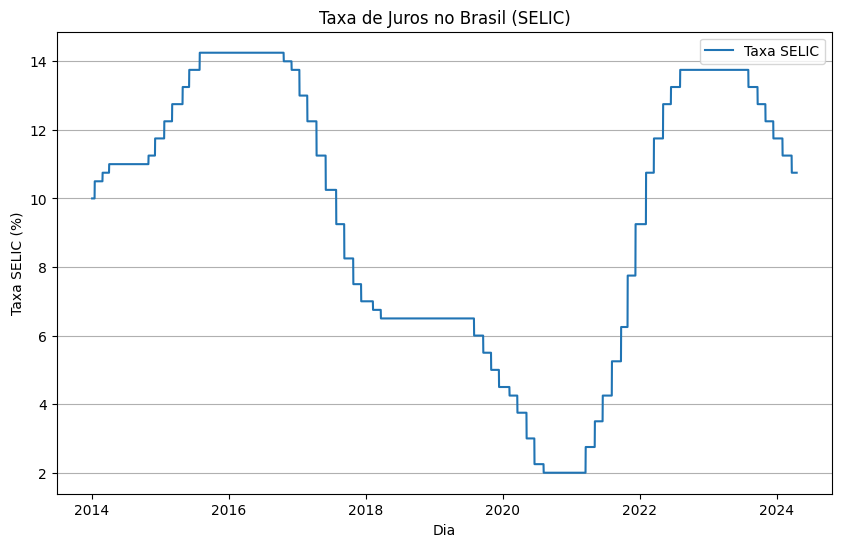

In [40]:
selic = sgs.get({'selic':432}, start = START_DATE, end = END_DATE)

plt.figure(figsize=(10, 6))

plt.plot(selic.index, selic['selic'], label='Taxa SELIC', color=colors['blue'])

plt.title('Taxa de Juros no Brasil (SELIC)')
plt.xlabel('Dia')
plt.ylabel('Taxa SELIC (%)')
plt.grid(axis='y')
plt.legend()
plt.show()

In [41]:
selic = pd.DataFrame(selic)
selic

selic
Date             
2014-01-02  10.00
2014-01-03  10.00
2014-01-04  10.00
2014-01-05  10.00
2014-01-06  10.00
...           ...
2024-04-12  10.75
2024-04-13  10.75
2024-04-14  10.75
2024-04-15  10.75
2024-04-16  10.75

[3758 rows x 1 columns]

In [42]:
selic.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3758 entries, 2014-01-02 to 2024-04-16
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   selic   3758 non-null   float64
dtypes: float64(1)
memory usage: 58.7 KB


In [43]:
selic.describe()

selic
count  3758.000000
mean      9.515766
std       4.035967
min       2.000000
25%       6.500000
50%      11.000000
75%      13.750000
max      14.250000

In [44]:
df = pd.merge(df, selic, left_on='Dia', right_on='Date', how='left')
df

Dia  Taxa Compra Manhã  Taxa Venda Manhã  PU Compra Manhã  \
0    2014-01-02               6.43              6.51          1217.75   
1    2014-01-03               6.47              6.55          1214.18   
2    2014-01-06               6.47              6.55          1214.80   
3    2014-01-07               6.48              6.56          1214.22   
4    2014-01-08               6.46              6.54          1217.26   
...         ...                ...               ...              ...   
2558 2024-04-10               7.44              7.56          4148.19   
2559 2024-04-11               7.53              7.65          4148.39   
2560 2024-04-12               7.60              7.72          4149.30   
2561 2024-04-15               7.48              7.60          4152.55   
2562 2024-04-16               7.51              7.63          4153.84   

      PU Venda Manhã  PU Base Manhã     CHF     USD       CL=F        ERJ  \
0            1208.11        1207.49  2.6603  2.3975  95.440002  32.130001   
1            1204.58        1203.33  2.6285  2.3741  93.959999  32.529999   
2            1205.20        1204.58  2.6301  2.3789  93.430000  32.250000   
3            1204.63        1204.01  2.6032  2.3634  93.669998  32.540001   
4            1207.64        1207.02  2.6142  2.3779  92.330002  32.520000   
...              ...            ...     ...     ...        ...        ...   
2558         4145.16        4145.16  5.5505  5.0654  86.209999  25.889999   
2559         4145.36        4145.36  5.5749  5.0765  85.019997  25.590000   
2560         4145.86        4145.86  5.6326  5.1364  85.660004  24.850000   
2561         4149.30        4149.30  5.6640  5.1746  85.410004  24.150000   
2562         4150.60        4150.60  5.7670  5.2635  85.360001  24.290001   

        PBR   VALE     ZS=F     ^BVSP  selic  
0     13.32  14.53  1287.00   50341.0  10.00  
1     13.12  14.33  1289.25   50981.0  10.00  
2     13.16  14.29  1296.75   50974.0  10.00  
3     12.90  14.04  1299.50   50430.0  10.00  
4     12.68  13.95  1300.75   50577.0  10.00  
...     ...    ...      ...       ...    ...  
2558  16.16  12.15  1164.75  128054.0  10.75  
2559  16.00  12.17  1159.25  127396.0  10.75  
2560  15.72  12.02  1174.00  125946.0  10.75  
2561  15.79  12.00  1158.25  125334.0  10.75  
2562  15.65  11.67  1145.00  124389.0  10.75  

[2563 rows x 15 columns]

### Expectativa IPCA

A Expectativa IPCA se refere à projeção ou expectativa de variação da taxa de inflação medida pelo IPCA (Índice de Preços ao Consumidor Amplo), que é o índice oficial de inflação no Brasil. Essa expectativa é baseada em diversas análises econômicas e fatores que podem influenciar os preços dos bens e serviços na economia, dessa forma, sendo crucial para a nossa análise.

In [45]:
em = Expectativas()
em.describe()

EntitySets:
  ExpectativasMercadoTop5Anuais
  ExpectativaMercadoMensais
  ExpectativasMercadoInflacao24Meses
  ExpectativasMercadoInflacao12Meses
  ExpectativasMercadoSelic
  ExpectativasMercadoTop5Selic
  ExpectativasMercadoTop5Mensais
  ExpectativasMercadoTrimestrais
  ExpectativasMercadoAnuais


In [46]:
ep = em.get_endpoint('ExpectativasMercadoAnuais')

In [47]:
collected_ipca = (ep.query()
 .filter(ep.Indicador == 'IPCA')
 .filter(ep.Data >= START_DATE)
 .filter(ep.Data <= END_DATE)
 .orderby(ep.Data.desc())
 .collect())

A seguir, estaremos coletando a média do IPCA para o ano corrente de cada medição, e selecionando aqueles valores que estiverem com baseCalculo = 0.

In [48]:
ipca_data = pd.DataFrame(collected_ipca)
ipca_data

Indicador IndicadorDetalhe       Data DataReferencia   Media  Mediana  \
0          IPCA             None 2024-04-16           2024  3.7137   3.7093   
1          IPCA             None 2024-04-16           2025  3.6431   3.5886   
2          IPCA             None 2024-04-16           2026  3.5251   3.5000   
3          IPCA             None 2024-04-16           2027  3.4855   3.5000   
4          IPCA             None 2024-04-16           2028  3.4424   3.5000   
...         ...              ...        ...            ...     ...      ...   
25805      IPCA             None 2014-01-02           2014  5.8900   5.9000   
25806      IPCA             None 2014-01-02           2013  5.7500   5.7800   
25807      IPCA             None 2014-01-02           2016  5.4100   5.5000   
25808      IPCA             None 2014-01-02           2017  5.3700   5.5000   
25809      IPCA             None 2014-01-02           2015  5.6500   5.5000   

       DesvioPadrao  Minimo  Maximo  numeroRespondentes  baseCalculo  
0            0.2492  2.9561  4.7171                 147            0  
1            0.3297  2.9993  5.0200                 144            0  
2            0.3709  3.0000  4.5000                 122            0  
3            0.3873  3.0000  5.0000                 113            0  
4            0.4034  3.0000  5.0000                  98            0  
...             ...     ...     ...                 ...          ...  
25805        0.3000  5.1500  6.5400                  27            1  
25806        0.0900  5.4700  5.8600                  27            1  
25807        0.4100  4.5000  6.5000                  22            1  
25808        0.4400  4.5000  6.5000                  19            1  
25809        0.4400  5.0000  6.8000                  25            1  

[25810 rows x 11 columns]

In [49]:
ipca_data['DataYear'] = ipca_data['Data'].dt.year

ipca_data['DataReferenciaYear'] = ipca_data['DataReferencia'].astype(int)

ipca_data = ipca_data[ipca_data['DataYear'] == ipca_data['DataReferenciaYear']]

ipca_data.drop(['DataYear', 'DataReferenciaYear'], axis=1, inplace=True)

C:\Users\Vitor\AppData\Local\Temp\ipykernel_28056\2297420668.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ipca_data.drop(['DataYear', 'DataReferenciaYear'], axis=1, inplace=True)


In [50]:
ipca_data

Indicador IndicadorDetalhe       Data DataReferencia   Media  Mediana  \
0          IPCA             None 2024-04-16           2024  3.7137   3.7093   
5          IPCA             None 2024-04-16           2024  3.6987   3.7000   
10         IPCA             None 2024-04-15           2024  3.7142   3.7094   
15         IPCA             None 2024-04-15           2024  3.7091   3.7055   
20         IPCA             None 2024-04-12           2024  3.7116   3.7093   
...         ...              ...        ...            ...     ...      ...   
25785      IPCA             None 2014-01-06           2014  5.8700   5.9000   
25794      IPCA             None 2014-01-03           2014  5.9500   5.9700   
25795      IPCA             None 2014-01-03           2014  5.9000   5.9400   
25804      IPCA             None 2014-01-02           2014  5.9400   5.9600   
25805      IPCA             None 2014-01-02           2014  5.8900   5.9000   

       DesvioPadrao  Minimo  Maximo  numeroRespondentes  baseCalculo  
0            0.2492  2.9561  4.7171                 147            0  
5            0.2658  2.9561  4.6700                  77            1  
10           0.2505  2.9561  4.7171                 147            0  
15           0.2705  2.9561  4.6700                  78            1  
20           0.2569  2.9561  4.7171                 151            0  
...             ...     ...     ...                 ...          ...  
25785        0.2400  5.1500  6.2900                  32            1  
25794        0.3000  5.1500  6.5400                 106            0  
25795        0.2900  5.1500  6.5400                  30            1  
25804        0.3000  5.1500  6.5400                 105            0  
25805        0.3000  5.1500  6.5400                  27            1  

[5162 rows x 11 columns]

In [51]:
ipca_data = ipca_data[ipca_data['baseCalculo'] == 0]
ipca_data.drop(['Indicador', 'IndicadorDetalhe', 'Mediana', 'Maximo', 'DesvioPadrao', 'DataReferencia', 'numeroRespondentes', 'baseCalculo'], axis=1, inplace=True)
ipca_data.columns = ['IPCA_' + col for col in ipca_data.columns]
ipca_data

C:\Users\Vitor\AppData\Local\Temp\ipykernel_28056\797347968.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ipca_data.drop(['Indicador', 'IndicadorDetalhe', 'Mediana', 'Maximo', 'DesvioPadrao', 'DataReferencia', 'numeroRespondentes', 'baseCalculo'], axis=1, inplace=True)


IPCA_Data  IPCA_Media  IPCA_Minimo
0     2024-04-16      3.7137       2.9561
10    2024-04-15      3.7142       2.9561
20    2024-04-12      3.7116       2.9561
30    2024-04-11      3.7110       2.9561
40    2024-04-10      3.7120       2.9665
...          ...         ...          ...
25761 2014-01-08      5.9600       5.1500
25771 2014-01-07      5.9500       5.1500
25784 2014-01-06      5.9500       5.1500
25794 2014-01-03      5.9500       5.1500
25804 2014-01-02      5.9400       5.1500

[2581 rows x 3 columns]

In [52]:
ipca_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2581 entries, 0 to 25804
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   IPCA_Data    2581 non-null   datetime64[ns]
 1   IPCA_Media   2581 non-null   float64       
 2   IPCA_Minimo  2581 non-null   float64       
dtypes: datetime64[ns](1), float64(2)
memory usage: 80.7 KB


In [53]:
ipca_data.describe()

IPCA_Data   IPCA_Media  IPCA_Minimo
count                           2581  2581.000000  2581.000000
mean   2019-02-21 21:31:35.544362752     5.410179     4.586781
min              2014-01-02 00:00:00     1.550000     0.500000
25%              2016-07-27 00:00:00     3.800000     3.030000
50%              2019-02-22 00:00:00     5.083100     4.100000
75%              2021-09-17 00:00:00     6.893900     6.030000
max              2024-04-16 00:00:00    10.700000    10.290000
std                              NaN     2.060477     2.025752

In [54]:
df = pd.merge(df, ipca_data, left_on='Dia', right_on=ipca_data['IPCA_Data'], how='left')
df.drop(['IPCA_Data'], axis=1, inplace=True)
df

Dia  Taxa Compra Manhã  Taxa Venda Manhã  PU Compra Manhã  \
0    2014-01-02               6.43              6.51          1217.75   
1    2014-01-03               6.47              6.55          1214.18   
2    2014-01-06               6.47              6.55          1214.80   
3    2014-01-07               6.48              6.56          1214.22   
4    2014-01-08               6.46              6.54          1217.26   
...         ...                ...               ...              ...   
2558 2024-04-10               7.44              7.56          4148.19   
2559 2024-04-11               7.53              7.65          4148.39   
2560 2024-04-12               7.60              7.72          4149.30   
2561 2024-04-15               7.48              7.60          4152.55   
2562 2024-04-16               7.51              7.63          4153.84   

      PU Venda Manhã  PU Base Manhã     CHF     USD       CL=F        ERJ  \
0            1208.11        1207.49  2.6603  2.3975  95.440002  32.130001   
1            1204.58        1203.33  2.6285  2.3741  93.959999  32.529999   
2            1205.20        1204.58  2.6301  2.3789  93.430000  32.250000   
3            1204.63        1204.01  2.6032  2.3634  93.669998  32.540001   
4            1207.64        1207.02  2.6142  2.3779  92.330002  32.520000   
...              ...            ...     ...     ...        ...        ...   
2558         4145.16        4145.16  5.5505  5.0654  86.209999  25.889999   
2559         4145.36        4145.36  5.5749  5.0765  85.019997  25.590000   
2560         4145.86        4145.86  5.6326  5.1364  85.660004  24.850000   
2561         4149.30        4149.30  5.6640  5.1746  85.410004  24.150000   
2562         4150.60        4150.60  5.7670  5.2635  85.360001  24.290001   

        PBR   VALE     ZS=F     ^BVSP  selic  IPCA_Media  IPCA_Minimo  
0     13.32  14.53  1287.00   50341.0  10.00      5.9400       5.1500  
1     13.12  14.33  1289.25   50981.0  10.00      5.9500       5.1500  
2     13.16  14.29  1296.75   50974.0  10.00      5.9500       5.1500  
3     12.90  14.04  1299.50   50430.0  10.00      5.9500       5.1500  
4     12.68  13.95  1300.75   50577.0  10.00      5.9600       5.1500  
...     ...    ...      ...       ...    ...         ...          ...  
2558  16.16  12.15  1164.75  128054.0  10.75      3.7120       2.9665  
2559  16.00  12.17  1159.25  127396.0  10.75      3.7110       2.9561  
2560  15.72  12.02  1174.00  125946.0  10.75      3.7116       2.9561  
2561  15.79  12.00  1158.25  125334.0  10.75      3.7142       2.9561  
2562  15.65  11.67  1145.00  124389.0  10.75      3.7137       2.9561  

[2563 rows x 17 columns]

Por fim, após a coleta desses índices macroeconômicos, é possível perceber uma boa correlação entre o IPCA e a taxa de compra, bem como uma correlação muito forte entre o SELIC e a taxa de compra.

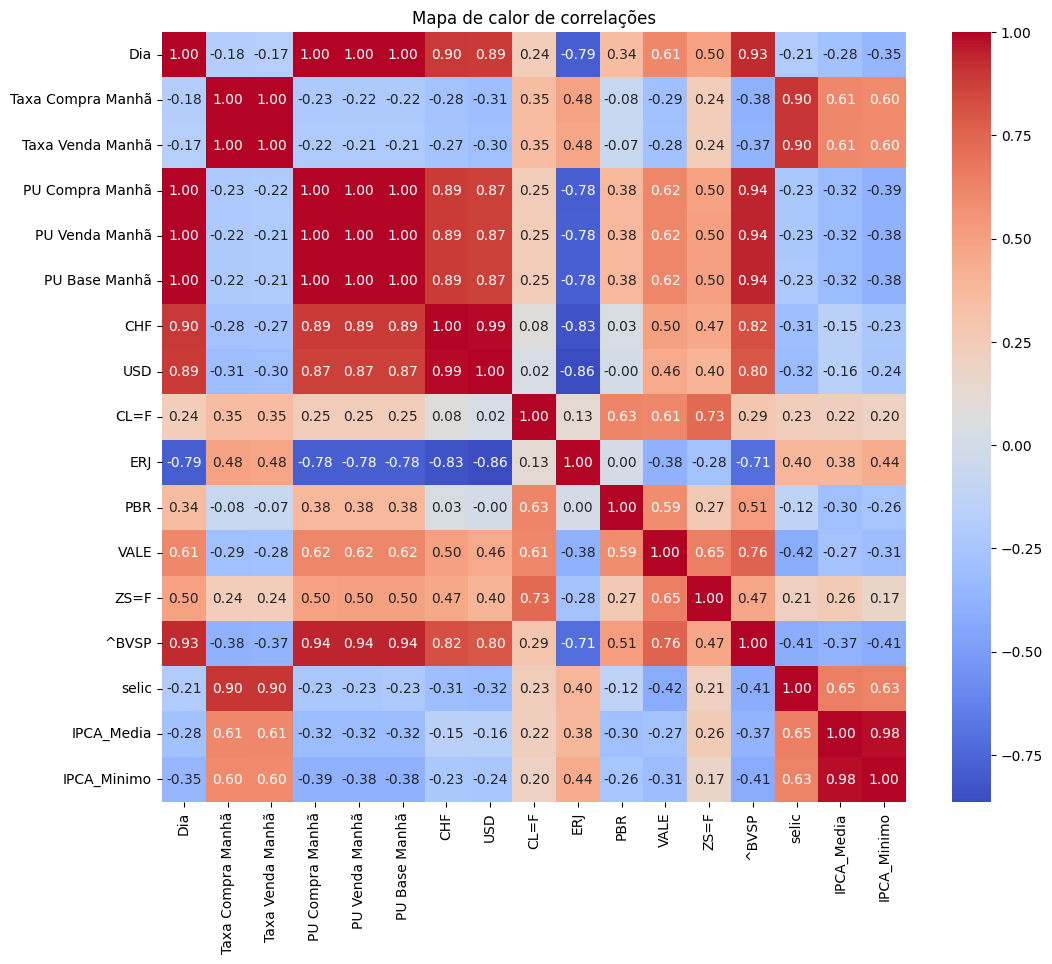

In [55]:
plot_corr_heatmap(df)

### Combine todas suas informações em um DataFrame

Após juntar (coletar) todas suas informações macroeconômicas, assim ficou o nosso DataFrame:

In [56]:
df.head(5)

Dia  Taxa Compra Manhã  Taxa Venda Manhã  PU Compra Manhã  \
0 2014-01-02               6.43              6.51          1217.75   
1 2014-01-03               6.47              6.55          1214.18   
2 2014-01-06               6.47              6.55          1214.80   
3 2014-01-07               6.48              6.56          1214.22   
4 2014-01-08               6.46              6.54          1217.26   

   PU Venda Manhã  PU Base Manhã     CHF     USD       CL=F        ERJ    PBR  \
0         1208.11        1207.49  2.6603  2.3975  95.440002  32.130001  13.32   
1         1204.58        1203.33  2.6285  2.3741  93.959999  32.529999  13.12   
2         1205.20        1204.58  2.6301  2.3789  93.430000  32.250000  13.16   
3         1204.63        1204.01  2.6032  2.3634  93.669998  32.540001  12.90   
4         1207.64        1207.02  2.6142  2.3779  92.330002  32.520000  12.68   

    VALE     ZS=F    ^BVSP  selic  IPCA_Media  IPCA_Minimo  
0  14.53  1287.00  50341.0   10.0        5.94         5.15  
1  14.33  1289.25  50981.0   10.0        5.95         5.15  
2  14.29  1296.75  50974.0   10.0        5.95         5.15  
3  14.04  1299.50  50430.0   10.0        5.95         5.15  
4  13.95  1300.75  50577.0   10.0        5.96         5.15

In [57]:
len(df)

2563

### Analisando nossos dados

Após visualizarmos as correlações previamente, agora chegou a vez de observarmos as tendências entre diferentes séries no nosso DataFrame.

In [58]:
df.set_index('Dia', inplace=True)

Neste primeiro gráfico, é possível perceber que as curvas da SELIC, Expectativa IPCA Média e da taxa de compra possuem formatos parecidos.

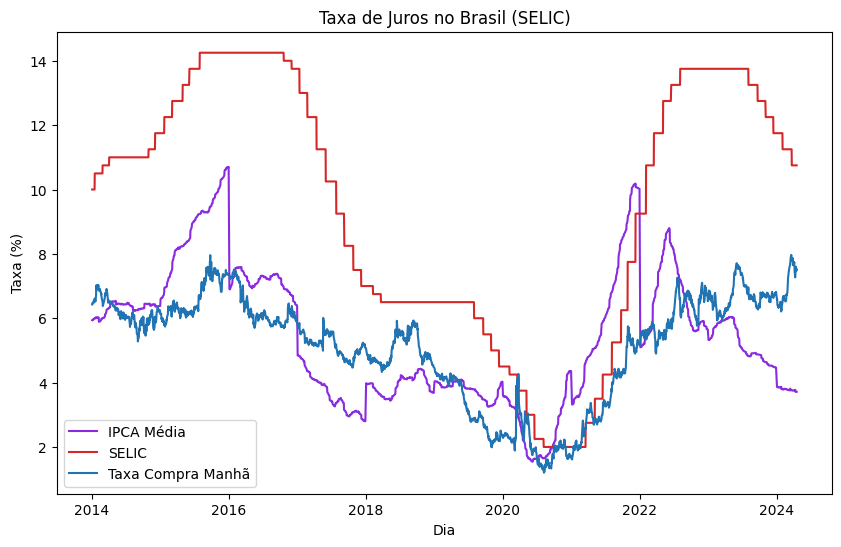

In [59]:
plt.figure(figsize=(10, 6))

plt.plot(df.index, df['IPCA_Media'], label='IPCA Média', color=colors['purple'])
plt.plot(df.index, df['selic'], label='SELIC', color=colors['red'])
plt.plot(df.index, df['Taxa Compra Manhã'], label='Taxa Compra Manhã', color=colors['blue'])

plt.title('Taxa de Juros no Brasil (SELIC)')
plt.xlabel('Dia')
plt.ylabel('Taxa (%)')

plt.grid(False)
plt.legend()

plt.show()

In [60]:
def plot_scatter(df: pd.DataFrame, x: str, y: str, title: str) -> None:
    plt.figure(figsize=(10, 6))

    plt.scatter(df[x], df[y], alpha=0.5, color=colors['blue'])

    plt.title(title)
    plt.xlabel(x)
    plt.ylabel(y)
    plt.grid(False)

    plt.show()

Neste scatter plot, é possível ver que à medida que a SELIC aumenta, também a taxa de compra.

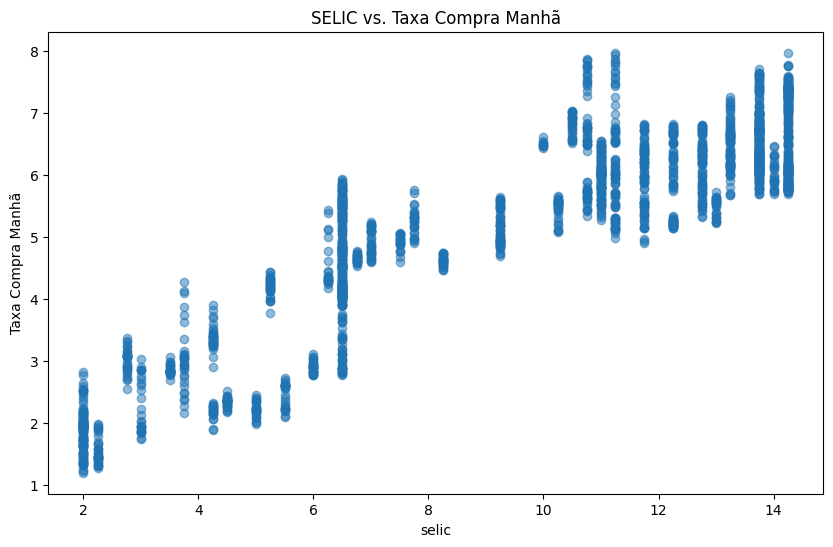

In [61]:
plot_scatter(df, x='selic', y='Taxa Compra Manhã', title="SELIC vs. Taxa Compra Manhã")

Já no caso do franco suíço, apesar de existir uma certa correlação, visualmente, é um tanto esparsa.

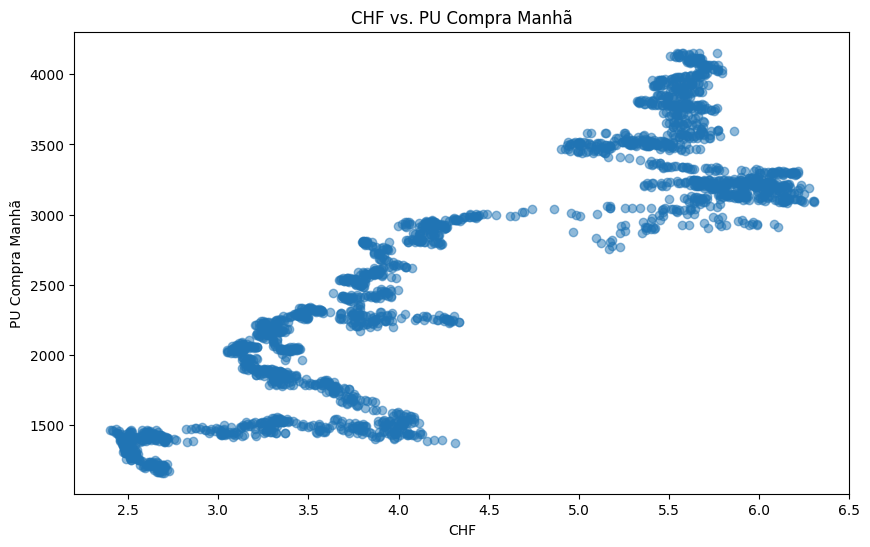

In [62]:
plot_scatter(df, x='CHF', y='PU Compra Manhã', title="CHF vs. PU Compra Manhã")

A correlação ainda é um tanto esparsa no caso da BOVESPA, entretanto, não tanto quanto o franco suíço.

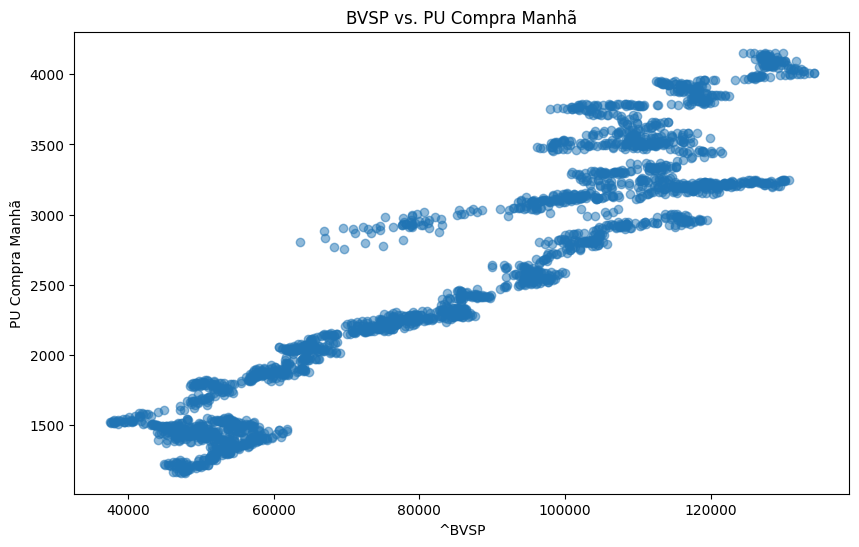

In [63]:
plot_scatter(df, x='^BVSP', y='PU Compra Manhã', title="BVSP vs. PU Compra Manhã")

Em vez do Scatter Plot, talvez seja mais interessante observar estes dados em forma de line chart, aonde fica muito mais evidente as tendências desses atributos em relação ao nosso rótulo.

Entretanto, ao plottar o gráfico, as escalas estão bem diferentes... Para realmente conseguirmos avaliar isto, revisitaremos este mesmo plot após normalização dos dados.

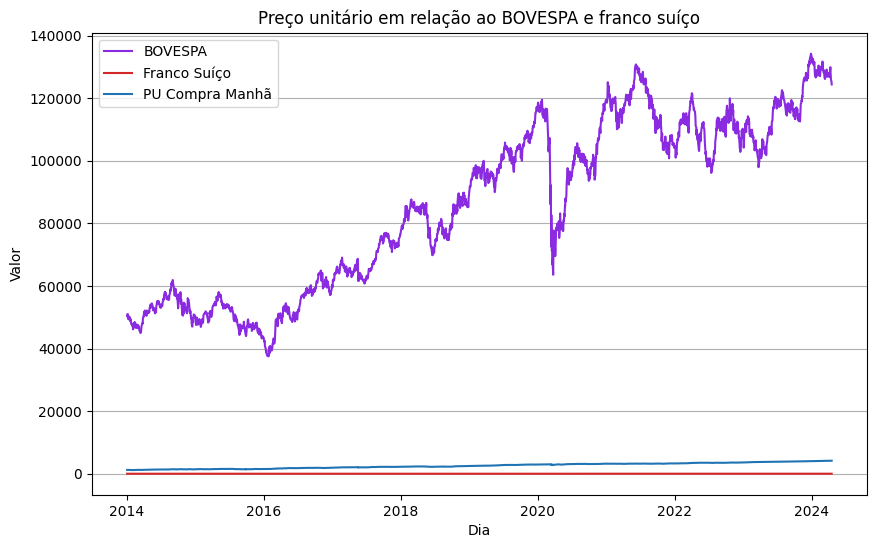

In [64]:
plt.figure(figsize=(10, 6))

plt.plot(df.index, df['^BVSP'], label='BOVESPA', color=colors['purple'])
plt.plot(df.index, df['CHF'], label='Franco Suíço', color=colors['red'])
plt.plot(df.index, df['PU Compra Manhã'], label='PU Compra Manhã', color=colors['blue'])

plt.title('Preço unitário em relação ao BOVESPA e franco suíço')
plt.xlabel('Dia')
plt.ylabel('Valor')

plt.grid(axis='y')
plt.legend()

plt.show()

Como podemos observar após plottar os box plots, o índice BOVESPA possui valores em uma escala muito maior. Vamos normalizar em um primeiro momento para que possamos fazer a identificação visual de outliers.

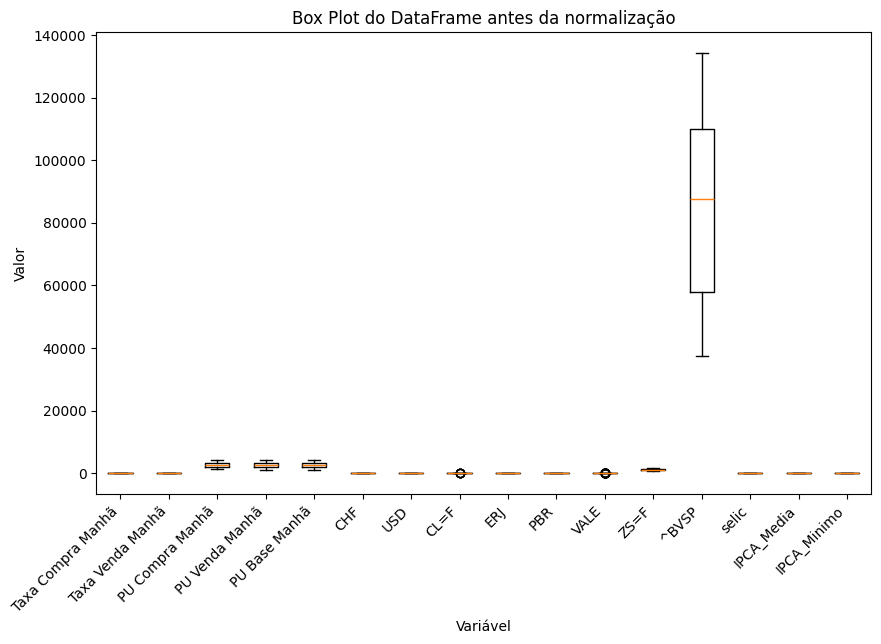

In [65]:
plt.figure(figsize=(10, 6))
plt.boxplot(df.values, labels=df.columns)
plt.title('Box Plot do DataFrame antes da normalização')
plt.xlabel('Variável')
plt.ylabel('Valor')
plt.xticks(rotation=45, ha='right')
plt.show()

Agora, com os dados normalizados, fica bem mais fácil perceber os outliers presentes no dataset. Vamos aplicar uma técnica de winsorização nestes valores e em seguida, realmente normalizar estes dados.

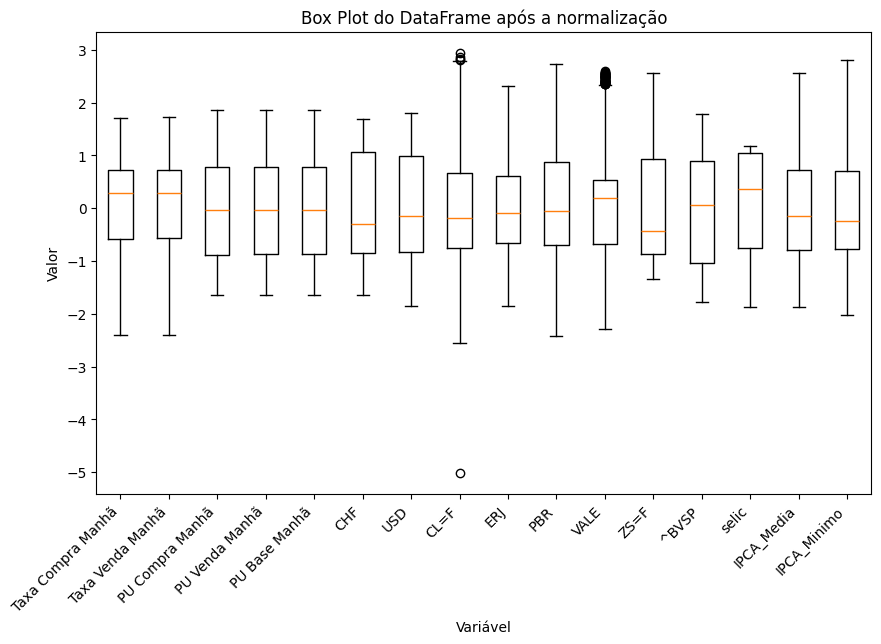

In [66]:
scaler = StandardScaler()

df_standardized = pd.DataFrame(scaler.fit_transform(df), columns=df.columns, index=df.index)

plt.figure(figsize=(10, 6))
plt.boxplot(df_standardized.values, labels=df.columns)
plt.title('Box Plot do DataFrame após a normalização')
plt.xlabel('Variável')
plt.ylabel('Valor')
plt.xticks(rotation=45, ha='right')
plt.show()

In [67]:
df = df.apply(lambda x: mstats.winsorize(x, limits=[0.02, 0.02]))

In [68]:
df_duplicated = df.copy() # Iremos, no futuro, utilizar o dataset não-normalizado para garantir que no split de treino e teste isso seja realizado de forma separada

Finalmente, temos o nosso dataset sem outliers e normalizado. Agora, podemos voltar a observar os gráficos:

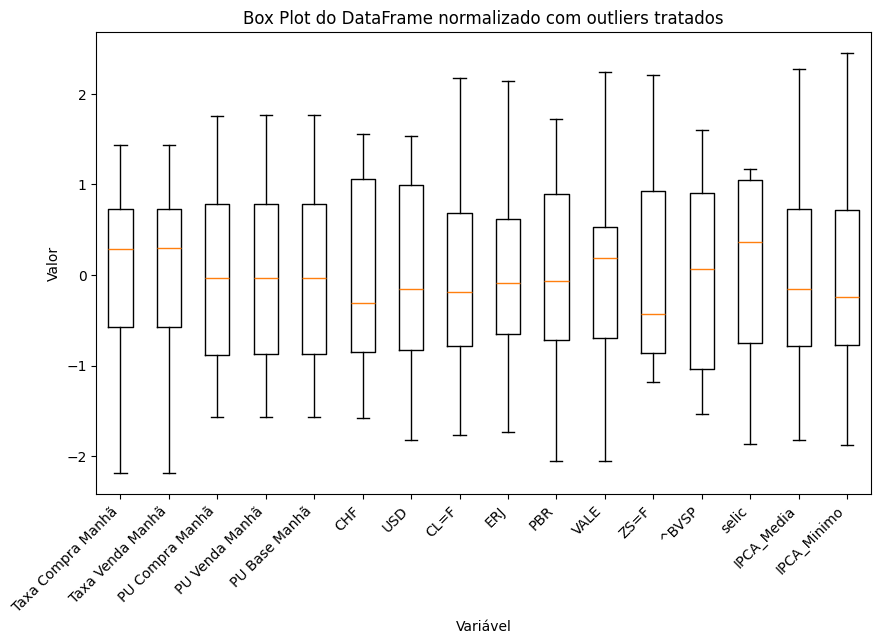

In [69]:
scaler = StandardScaler()

df = pd.DataFrame(scaler.fit_transform(df), columns=df.columns, index=df.index)

plt.figure(figsize=(10, 6))
plt.boxplot(df.values, labels=df.columns)
plt.title('Box Plot do DataFrame normalizado com outliers tratados')
plt.xlabel('Variável')
plt.ylabel('Valor')
plt.xticks(rotation=45, ha='right')
plt.show()

Agora, é bem fácil de visualizar que o franco suíço, o BOVESPA e o Preço Unitário de Compra seguem a mesma tendência.

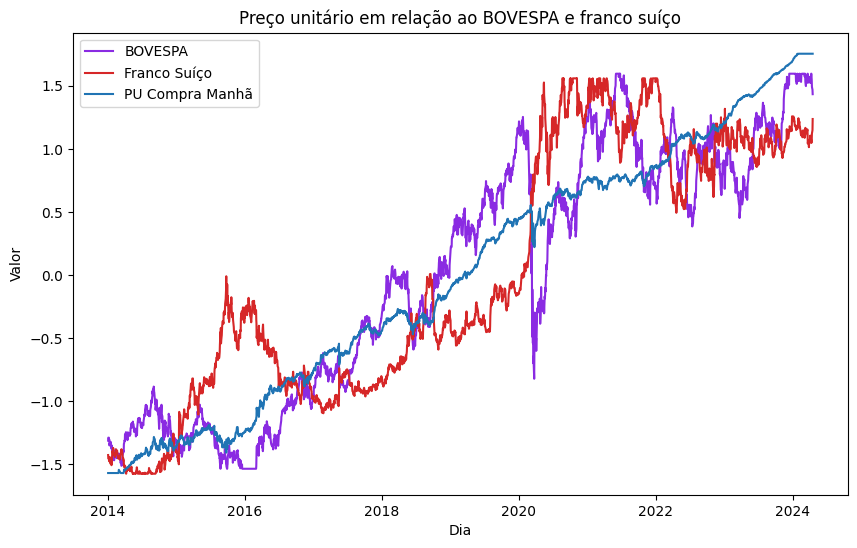

In [70]:
plt.figure(figsize=(10, 6))

plt.plot(df.index, df['^BVSP'], label='BOVESPA', color=colors['purple'])
plt.plot(df.index, df['CHF'], label='Franco Suíço', color=colors['red'])
plt.plot(df.index, df['PU Compra Manhã'], label='PU Compra Manhã', color=colors['blue'])

plt.title('Preço unitário em relação ao BOVESPA e franco suíço')
plt.xlabel('Dia')
plt.ylabel('Valor')

plt.grid(False)
plt.legend()

plt.show()

Bem como fica bem mais fácil de visualizar como o SELIC, a expectativa de IPCA média e a Taxa de Compra seguem tendências similares.

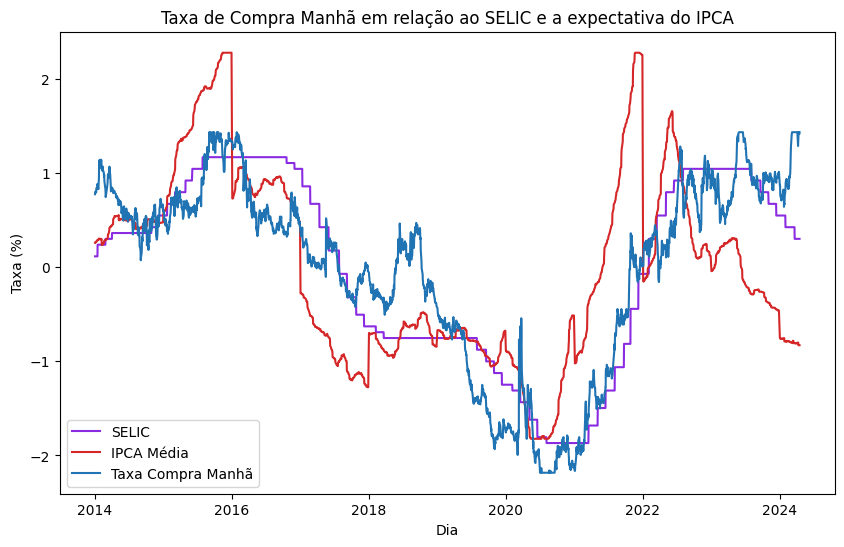

In [71]:
plt.figure(figsize=(10, 6))

plt.plot(df.index, df['selic'], label='SELIC', color=colors['purple'])
plt.plot(df.index, df['IPCA_Media'], label='IPCA Média', color=colors['red'])
plt.plot(df.index, df['Taxa Compra Manhã'], label='Taxa Compra Manhã', color=colors['blue'])

plt.title('Taxa de Compra Manhã em relação ao SELIC e a expectativa do IPCA')
plt.xlabel('Dia')
plt.ylabel('Taxa (%)')

plt.grid(False)
plt.legend()

plt.show()

## Parte II - Pré-Processamento

Proponha uma pipeline de pré-processamento dos dados para regressão, se você achar necessário.


**Pontuação: 10 pontos**

In [72]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2563 entries, 2014-01-02 to 2024-04-16
Data columns (total 16 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Taxa Compra Manhã  2563 non-null   float64
 1   Taxa Venda Manhã   2563 non-null   float64
 2   PU Compra Manhã    2563 non-null   float64
 3   PU Venda Manhã     2563 non-null   float64
 4   PU Base Manhã      2563 non-null   float64
 5   CHF                2563 non-null   float64
 6   USD                2563 non-null   float64
 7   CL=F               2563 non-null   float64
 8   ERJ                2563 non-null   float64
 9   PBR                2563 non-null   float64
 10  VALE               2563 non-null   float64
 11  ZS=F               2563 non-null   float64
 12  ^BVSP              2563 non-null   float64
 13  selic              2563 non-null   float64
 14  IPCA_Media         2563 non-null   float64
 15  IPCA_Minimo        2563 non-null   float64
dtypes: flo

<Axes: ylabel='Dia'>

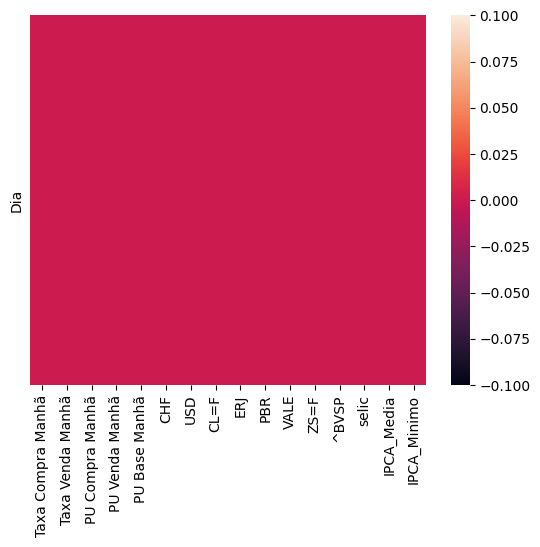

In [73]:
sns.heatmap(df.isnull(), yticklabels=False)

In [74]:
df.describe()

Taxa Compra Manhã  Taxa Venda Manhã  PU Compra Manhã  PU Venda Manhã  \
count       2.563000e+03      2.563000e+03     2.563000e+03    2.563000e+03   
mean        1.330708e-16      6.653541e-17    -8.871388e-17    2.661416e-16   
std         1.000195e+00      1.000195e+00     1.000195e+00    1.000195e+00   
min        -2.183861e+00     -2.190235e+00    -1.570939e+00   -1.568012e+00   
25%        -5.788672e-01     -5.733412e-01    -8.807251e-01   -8.764960e-01   
50%         2.877073e-01      2.935105e-01    -3.251875e-02   -3.755302e-02   
75%         7.331999e-01      7.238624e-01     7.831526e-01    7.824541e-01   
max         1.435003e+00      1.437017e+00     1.754880e+00    1.762430e+00   

       PU Base Manhã           CHF           USD          CL=F           ERJ  \
count   2.563000e+03  2.563000e+03  2.563000e+03  2.563000e+03  2.563000e+03   
mean   -1.774278e-16  1.774278e-16 -8.871388e-17  1.330708e-16 -1.774278e-16   
std     1.000195e+00  1.000195e+00  1.000195e+00  1.000195e+00  1.000195e+00   
min    -1.567535e+00 -1.576435e+00 -1.823027e+00 -1.763080e+00 -1.737941e+00   
25%    -8.765883e-01 -8.559932e-01 -8.302093e-01 -7.831085e-01 -6.544875e-01   
50%    -3.839337e-02 -3.081550e-01 -1.507173e-01 -1.911594e-01 -8.763209e-02   
75%     7.813223e-01  1.063714e+00  9.898902e-01  6.804912e-01  6.153856e-01   
max     1.762724e+00  1.559522e+00  1.531984e+00  2.174095e+00  2.147064e+00   

                PBR          VALE          ZS=F        ^BVSP         selic  \
count  2.563000e+03  2.563000e+03  2.563000e+03  2563.000000  2.563000e+03   
mean   2.217847e-16 -8.871388e-17  2.217847e-16     0.000000 -1.330708e-16   
std    1.000195e+00  1.000195e+00  1.000195e+00     1.000195  1.000195e+00   
min   -2.054569e+00 -2.053046e+00 -1.179983e+00    -1.537059 -1.868457e+00   
25%   -7.148772e-01 -6.943701e-01 -8.627368e-01    -1.037186 -7.524628e-01   
50%   -6.281461e-02  1.891279e-01 -4.258320e-01     0.064026  3.635315e-01   
75%    8.915673e-01  5.353635e-01  9.301316e-01     0.904687  1.045528e+00   
max    1.721465e+00  2.240276e+00  2.209674e+00     1.596415  1.169527e+00   

         IPCA_Media   IPCA_Minimo  
count  2.563000e+03  2.563000e+03  
mean   2.217847e-17 -1.108924e-16  
std    1.000195e+00  1.000195e+00  
min   -1.823374e+00 -1.876982e+00  
25%   -7.864632e-01 -7.753303e-01  
50%   -1.534094e-01 -2.419516e-01  
75%    7.297747e-01  7.201241e-01  
max    2.279614e+00  2.449866e+00

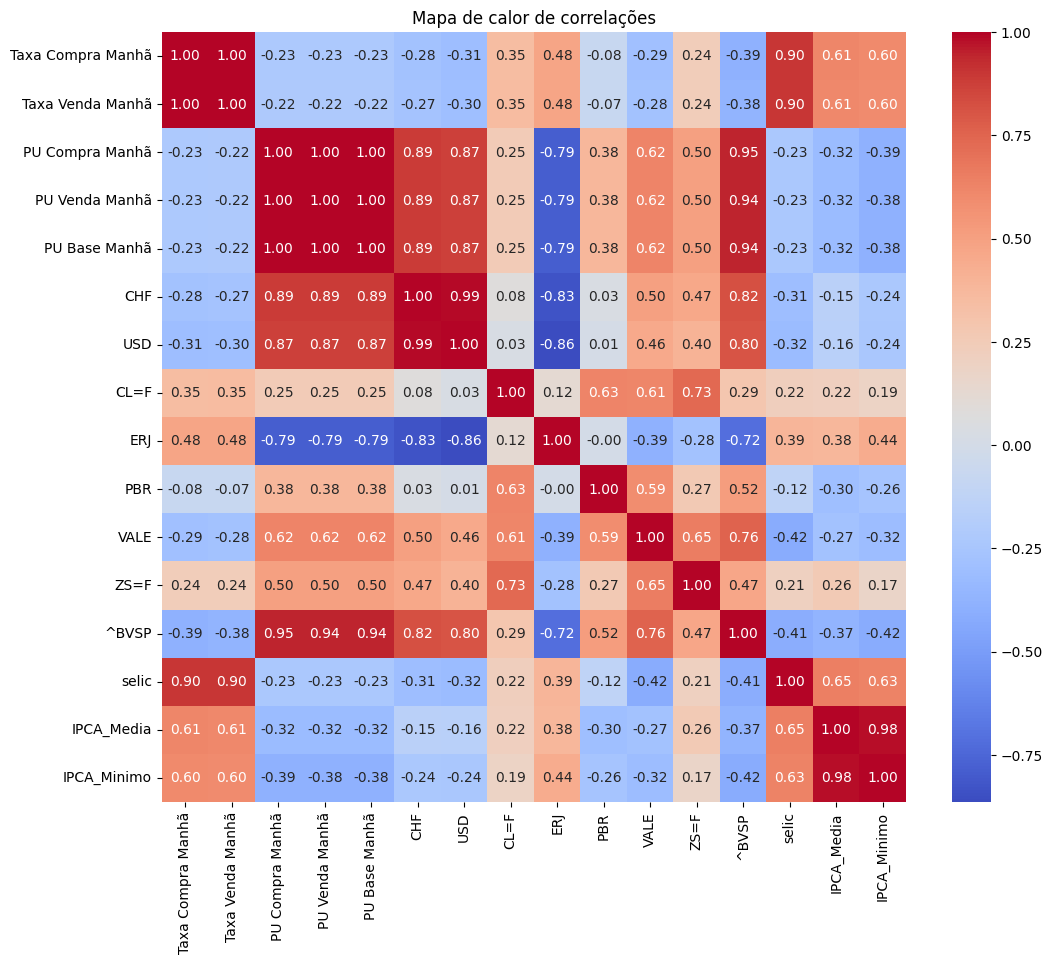

In [75]:
plot_corr_heatmap(df)

### Separação em dados de treino e teste

Sugestao de nomenclatura:

- X_train: dados para construcao de um futuro modelo.
- X_test:  dados para testar um futuro modelo.
- y_train: label para os dados referentes ao conjunto de treinamento.
- y_test:  label para os dados referentes ao conjunto de teste.

In [76]:
def standard_scale(
    X_train: pd.DataFrame,
    X_test: pd.DataFrame,
    columns: pd.Index
) -> None:
    for column in columns:
      scaler = StandardScaler()
      X_train[column] = scaler.fit_transform(X_train[[column]])
      X_test[column] = scaler.transform(X_test[[column]])

Neste caso, como o PU e a Taxa de Venda possuem uma relação matemática, vamos apenas manter o PU de compra para as nossas análises.

In [77]:
y = df_duplicated['PU Compra Manhã']
X = df_duplicated.drop(['PU Venda Manhã', 'PU Compra Manhã', 'PU Base Manhã', 'Taxa Venda Manhã', 'Taxa Compra Manhã'], axis = 1)

In [78]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
standard_scale(X_train, X_test, X_train.columns)

In [79]:
normal_y_test = y_test.copy()

### Testando a distribuição

Pudemos perceber que neste split, os dados de treino, teste e do dataframe para o rótulo seguem a mesma distribuição.

In [80]:
def print_ks_res(series1: pd.Series, series2: pd.Series, alpha: float = 0.05) -> None:
    statistic, p_value = ks_2samp(series1, series2)

    print("KS Statistic:", statistic)
    print("P-value:", p_value)

    if p_value > alpha:
        print("Similar (fail to reject H0)")
    else:
        print("Different (reject H0)")

In [81]:
print_ks_res(y_train, df_duplicated['PU Compra Manhã'])

KS Statistic: 0.010901209259111852
P-value: 0.9994730911534357
Similar (fail to reject H0)


In [82]:
print_ks_res(y_test, df_duplicated['PU Compra Manhã'])

KS Statistic: 0.025431429662999563
P-value: 0.8272150538320652
Similar (fail to reject H0)


## Parte III - Experimentos

O objetivo desta prática é avaliar as seguintes técnicas de regressão:

- Regressão Linear
- k-NN para regressão
- Regressão com Árvore de Decisão
- __Método de regressão que você acha interessante avaliar__


**Pontuação 50 pontos**

O experimento adotado para as próximas modelagens visa:
- Realizar validação cruzada para observar a generalização do modelo bem como obter seus melhores parâmetros.
- Realizar um teste na base de treino e de teste - com os melhores parâmetros encontrados a partir da validação cruzada - para entender o seu viés
- Analisar quais foram as features mais influentes para cada modelo de machine learning utilizado

### Experimento (0) - Funções a serem reutilizadas

O intuito deste bloco é armazenar as funções a serem reutilizadas nos experimentos que virão a seguir.

In [83]:
def plot_feature_importance_linear(model: any, feature_names: list[str]) -> None:
    coefficients = model.coef_
    feature_importance = pd.DataFrame({'Feature': feature_names, 'Coefficient': coefficients})

    feature_importance = feature_importance.reindex(feature_importance['Coefficient'].abs().sort_values(ascending=False).index)

    plt.figure(figsize=(10, 6))
    plt.bar(feature_importance['Feature'], feature_importance['Coefficient'])
    plt.title('Importância de atributos (Coeficientes)')
    plt.xlabel('Atributo')
    plt.ylabel('Coeficiente')
    plt.xticks(rotation=45, ha='right') 
    plt.show()

In [84]:
def plot_feature_importance_knn(
    model: any, 
    X_train: pd.DataFrame, 
    feature_names: list[str]
) -> None:
    feature_importance = {}
    base_predictions = model.predict(X_train)
    for feature_name in feature_names:
        X_perturbed = X_train.copy()
        X_perturbed[feature_name] = np.random.permutation(X_train[feature_name])
        perturbed_predictions = model.predict(X_perturbed)
        importance = np.mean(np.abs(base_predictions - perturbed_predictions))
        feature_importance[feature_name] = importance

    sorted_features = sorted(feature_importance.items(), key=lambda x: x[1], reverse=True)
    sorted_feature_names = [x[0] for x in sorted_features]
    sorted_importances = [x[1] for x in sorted_features]

    plt.figure(figsize=(10, 6))
    plt.bar(sorted_feature_names, sorted_importances)
    plt.title('Importância de atributos (Coeficientes)')
    plt.xlabel('Atributo')
    plt.ylabel('Coeficiente')
    plt.xticks(rotation=45, ha='right')
    plt.show()

In [85]:
def plot_feature_importance_dt(model: any, feature_names: list[str]) -> None:
    importances = model.feature_importances_
    feature_importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
    feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

    plt.figure(figsize=(10, 6))
    plt.bar(feature_importance_df['Feature'], feature_importance_df['Importance'])
    plt.title('Importância de atributos (Coeficientes)')
    plt.xlabel('Atributo')
    plt.ylabel('Coeficiente')
    plt.xticks(rotation=45, ha='right')
    plt.show()

In [86]:
def print_regression_metrics(
    actual: pd.Series,
    predicted: pd.Series
) -> None:
    score = r2_score(actual, predicted)
    mae = mean_absolute_error(actual, predicted)
    mse = mean_squared_error(actual, predicted)
    rmse = np.sqrt(mse)

    print(f"Mean Absolute Error (MAE): {mae:.4f}")
    print(f"Mean Squared Error (MSE): {mse:.4f}")
    print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")
    print(f"R2-Score: {score:.4f}")

In [87]:
def print_regression_cv_metrics(
    cv_results: any,
    param: str = 'mean_test_r2'
) -> None:
    if param == 'mean_test_r2':
        best_index = cv_results[param].argmax()  # Get the index of the best parameters based on R2 score
    else:
        best_index = cv_results[param].argmin()
    print(f"Best Params: {cv_results['params'][best_index]}")
    print(f"MAE: {cv_results['mean_test_neg_mean_absolute_error'][best_index]:.4f} ± {cv_results['std_test_neg_mean_absolute_error'][best_index]:.4f}")
    print(f"MSE: {cv_results['mean_test_neg_mean_squared_error'][best_index]:.4f} ± {cv_results['std_test_neg_mean_squared_error'][best_index]:.4f}")
    print(f"R2: {cv_results['mean_test_r2'][best_index]:.4f} ± {cv_results['std_test_r2'][best_index]:.4f}")

In [88]:
def plot_regression_scatter(
    X: pd.DataFrame,
    y_actual: pd.Series,
    y_pred: pd.Series,
    title: str
) -> None:
    plt.figure(figsize=(10, 6))
    
    plt.scatter(X.index, y_actual, color=colors['gray'], label='Real', alpha=0.6, s=5)
    
    plt.scatter(X.index, y_pred, color=colors['blue'], label='Predito', alpha=0.6, s=5)
    
    plt.title(title)
    plt.xlabel('Data')
    plt.ylabel('Preço Unitário')
    
    plt.legend()
    
    plt.grid(False)
    
    plt.show()

In [89]:
scoring = {'neg_mean_absolute_error': make_scorer(mean_absolute_error),
           'neg_mean_squared_error': make_scorer(mean_squared_error),
           'r2': make_scorer(r2_score)}

### Experimento (1) - Regressão Linear

Vamos ver como serão os nossos resultados ao utilizar uma Regressão Linear multivariada.

#### Validação Cruzada

In [90]:
linear_parameters = {'fit_intercept':[True,False], 'copy_X':[True,False]}
linear_cv_results = []

for cv in range(3, 10):
    grid = GridSearchCV(LinearRegression(), linear_parameters, cv=cv, scoring=scoring, refit=False)

    grid.fit(X_train, y_train)
    linear_cv_results.append(grid)

    print(f"\nCV: {cv}")
    print_regression_cv_metrics(grid.cv_results_)


CV: 3
Best Params: {'copy_X': True, 'fit_intercept': True}
MAE: 84.2155 ± 1.9042
MSE: 12605.9757 ± 497.6163
R2: 0.9825 ± 0.0006

CV: 4
Best Params: {'copy_X': True, 'fit_intercept': True}
MAE: 84.2403 ± 1.7040
MSE: 12633.9102 ± 522.5089
R2: 0.9824 ± 0.0010

CV: 5
Best Params: {'copy_X': True, 'fit_intercept': True}
MAE: 84.2511 ± 1.2244
MSE: 12646.5298 ± 513.0513
R2: 0.9824 ± 0.0009

CV: 6
Best Params: {'copy_X': True, 'fit_intercept': True}
MAE: 84.0579 ± 2.3606
MSE: 12577.4060 ± 688.9927
R2: 0.9824 ± 0.0009

CV: 7
Best Params: {'copy_X': True, 'fit_intercept': True}
MAE: 84.0146 ± 1.7665
MSE: 12583.2383 ± 507.2542
R2: 0.9824 ± 0.0009

CV: 8
Best Params: {'copy_X': True, 'fit_intercept': True}
MAE: 84.0590 ± 3.6082
MSE: 12591.7977 ± 946.4285
R2: 0.9824 ± 0.0014

CV: 9
Best Params: {'copy_X': True, 'fit_intercept': True}
MAE: 84.0643 ± 3.7381
MSE: 12609.5589 ± 1049.3756
R2: 0.9824 ± 0.0013


Dessa forma, todos os folds obtiveram melhor resultado utilizando copy_X e fit_intercept como true. Além disso, foi possível observar que os erros quadráticos médios possuem valores elevados, indicando que apesar do R2 possuir um valor muito próximo de 1, o modelo ainda está errando por muito nos valores preditos.

#### Avaliando para a base de treino e teste

In [91]:
model = LinearRegression(copy_X=True, fit_intercept=True)

model.fit(X_train, y_train)

y_pred = model.predict(X_test)
y_pred_train = model.predict(X_train)

print("===== Results for test =====")
print_regression_metrics(y_test, y_pred)
print()

print("===== Results for train =====")
print_regression_metrics(y_train, y_pred_train)
print()

===== Results for test =====
Mean Absolute Error (MAE): 88.2500
Mean Squared Error (MSE): 13538.8954
Root Mean Squared Error (RMSE): 116.3568
R2-Score: 0.9816

===== Results for train =====
Mean Absolute Error (MAE): 83.5504
Mean Squared Error (MSE): 12431.3827
Root Mean Squared Error (RMSE): 111.4961
R2-Score: 0.9828



In [92]:
normal_lr_pred = y_pred.copy()

Para a base de treino e teste, o padrão se manteve mesmo na base de treino. Desta forma, é possível afirmar que o modelo não está performando muito bem neste sentido.

Ao visualizar os gráficos, é possível visualizar diversos pontos preditos que estão um tanto distantes dos atuais, e consequentemente, fazendo com que o modelo tenha sua MSE punida.

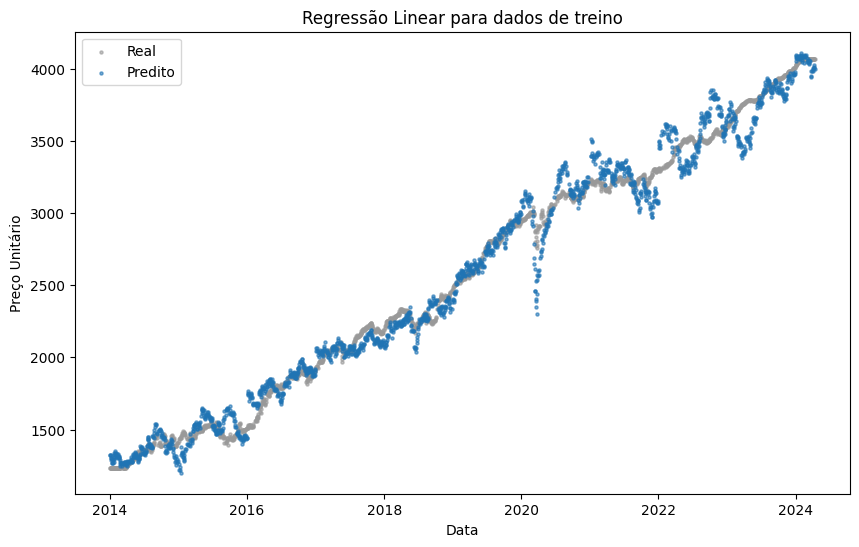

In [93]:
plot_regression_scatter(X_train, y_train, y_pred_train, title="Regressão Linear para dados de treino")

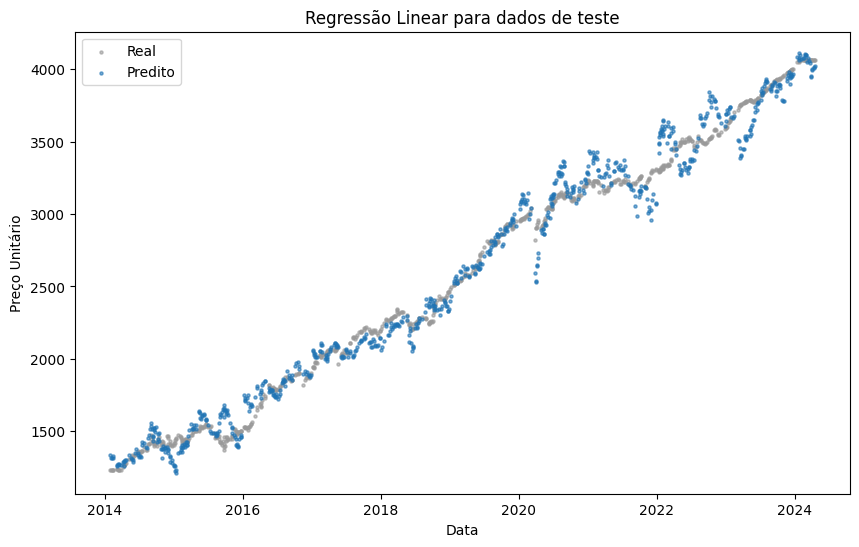

In [94]:
plot_regression_scatter(X_test, y_test, y_pred, title="Regressão Linear para dados de teste")

#### Analisando a importância das features

Neste gráfico, podemos observar a importância de cada característica para o modelo

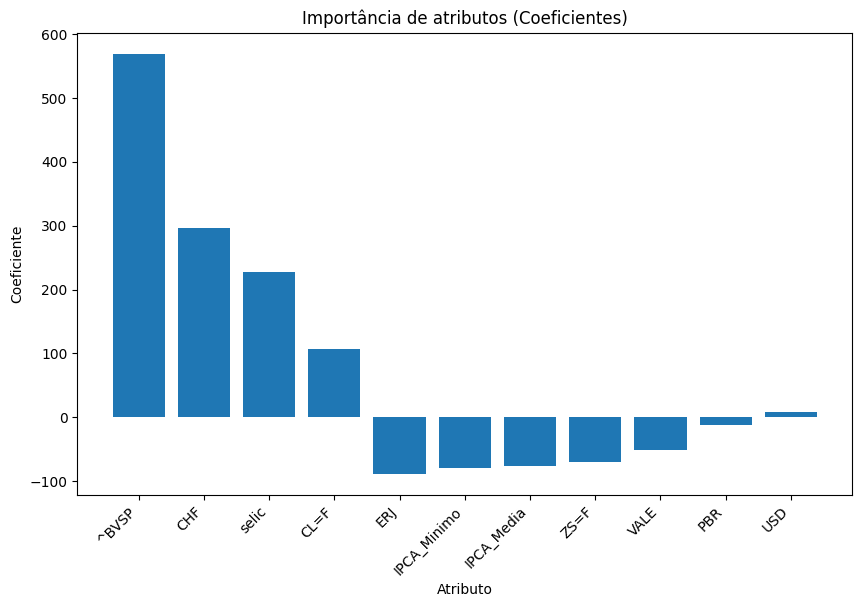

In [95]:
plot_feature_importance_linear(model, X.columns)

### Experimento (2) - Regressão com k-NN

#### Validação Cruzada

In [96]:
k_range = range(3, 10)

knn_param_grid = {
    'n_neighbors': k_range,
    'metric': ['minkowski', 'euclidean', 'manhattan']
}

knn_cv_results = []

for k in k_range:
    grid = GridSearchCV(KNeighborsRegressor(), knn_param_grid, cv=k, scoring=scoring, refit=False)
    grid.fit(X_train, y_train)
    knn_cv_results.append(grid)

    print(f"\nCV: {k}")
    print_regression_cv_metrics(grid.cv_results_)


CV: 3
Best Params: {'metric': 'manhattan', 'n_neighbors': 3}
MAE: 9.3977 ± 0.3119
MSE: 214.9012 ± 18.4855
R2: 0.9997 ± 0.0000

CV: 4
Best Params: {'metric': 'manhattan', 'n_neighbors': 3}
MAE: 8.7339 ± 0.3520
MSE: 193.4146 ± 24.3019
R2: 0.9997 ± 0.0000

CV: 5
Best Params: {'metric': 'manhattan', 'n_neighbors': 3}
MAE: 8.5347 ± 0.5891
MSE: 179.5725 ± 40.4898
R2: 0.9997 ± 0.0001

CV: 6
Best Params: {'metric': 'manhattan', 'n_neighbors': 3}
MAE: 8.4574 ± 0.6326
MSE: 184.7858 ± 40.4478
R2: 0.9997 ± 0.0001

CV: 7
Best Params: {'metric': 'manhattan', 'n_neighbors': 3}
MAE: 8.0479 ± 0.4600
MSE: 152.7000 ± 27.1146
R2: 0.9998 ± 0.0000

CV: 8
Best Params: {'metric': 'manhattan', 'n_neighbors': 3}
MAE: 8.0916 ± 0.5171
MSE: 158.5808 ± 39.3649
R2: 0.9998 ± 0.0001

CV: 9
Best Params: {'metric': 'manhattan', 'n_neighbors': 3}
MAE: 8.1612 ± 0.6701
MSE: 161.8573 ± 52.0885
R2: 0.9998 ± 0.0001


Já para o KNN, podemos perceber uma leve melhora para o R2, e uma melhora de ordens de grandeza no MAE e MSE.

In [97]:
for grid in knn_cv_results:
    best_index = grid.cv_results_['mean_test_r2'].argmax()
    print(f"Best Params: {grid.cv_results_['params'][best_index]}")

Best Params: {'metric': 'manhattan', 'n_neighbors': 3}
Best Params: {'metric': 'manhattan', 'n_neighbors': 3}
Best Params: {'metric': 'manhattan', 'n_neighbors': 3}
Best Params: {'metric': 'manhattan', 'n_neighbors': 3}
Best Params: {'metric': 'manhattan', 'n_neighbors': 3}
Best Params: {'metric': 'manhattan', 'n_neighbors': 3}
Best Params: {'metric': 'manhattan', 'n_neighbors': 3}


Ademais, podemos perceber que dentre as fórmulas de distâncias fornecidas, a distância de Manhattan foi a melhor, com n_neighbors de 3.

In [98]:
best_knn_cv_result = max(knn_cv_results, key=lambda x: x.cv_results_['mean_test_r2'].argmax())

In [99]:
best_index = best_knn_cv_result.cv_results_['mean_test_r2'].argmax()
best_knn_cv_result.cv_results_['params'][best_index]

{'metric': 'manhattan', 'n_neighbors': 3}

#### Avaliando para a base de testes e treino

In [100]:
knn = KNeighborsRegressor(metric='manhattan', n_neighbors=3)

knn.fit(X_train, y_train)

y_pred = knn.predict(X_test)
y_pred_train = knn.predict(X_train)

print("===== Results for test =====")
print_regression_metrics(y_test, y_pred)
print()

print("===== Results for train =====")
print_regression_metrics(y_train, y_pred_train)
print()

===== Results for test =====
Mean Absolute Error (MAE): 7.6684
Mean Squared Error (MSE): 126.8421
Root Mean Squared Error (RMSE): 11.2624
R2-Score: 0.9998

===== Results for train =====
Mean Absolute Error (MAE): 5.1214
Mean Squared Error (MSE): 66.7184
Root Mean Squared Error (RMSE): 8.1681
R2-Score: 0.9999



In [101]:
normal_knn_pred = y_pred.copy()

Por fim, é possível notar que o padrão encontrado para os folds da validação cruzada se manteve para as bases de teste e treino.

Visualmente, podemos perceber os pontos preditos muito mais próximos da linha dos valores reais.

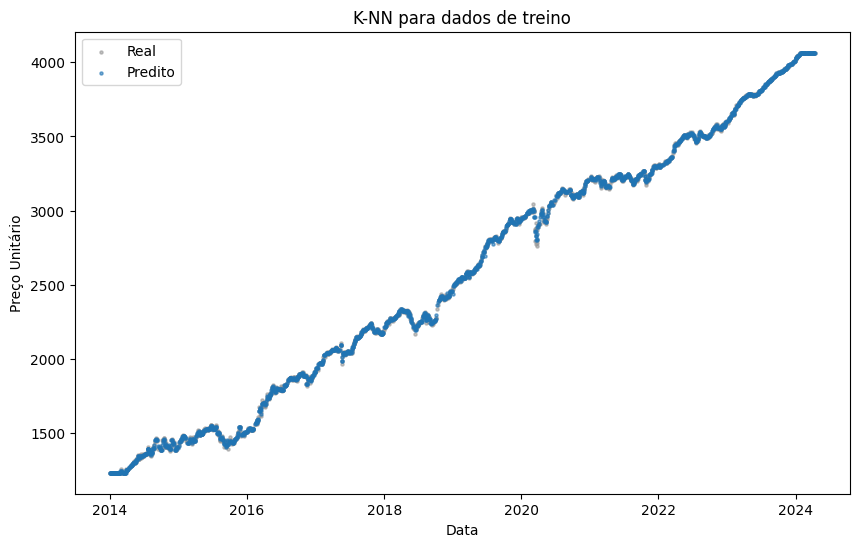

In [102]:
plot_regression_scatter(X_train, y_train, y_pred_train, title="K-NN para dados de treino")

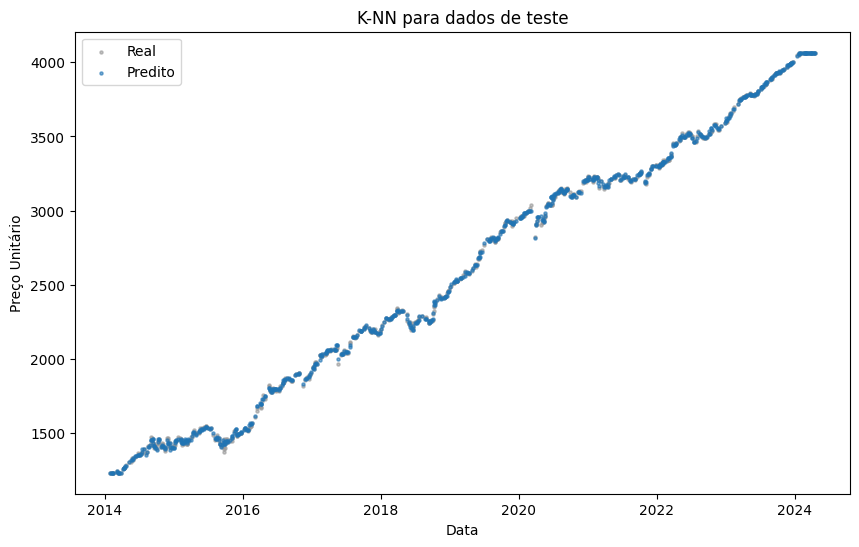

In [103]:
plot_regression_scatter(X_test, y_test, y_pred, title="K-NN para dados de teste")

#### Analisando a importância das features

As features mais importantes mudaram um tanto, a Petrobras assumindo a posição da BOVESPA, que nesse modelo, ficou bem atrás do que no da regressão linear.

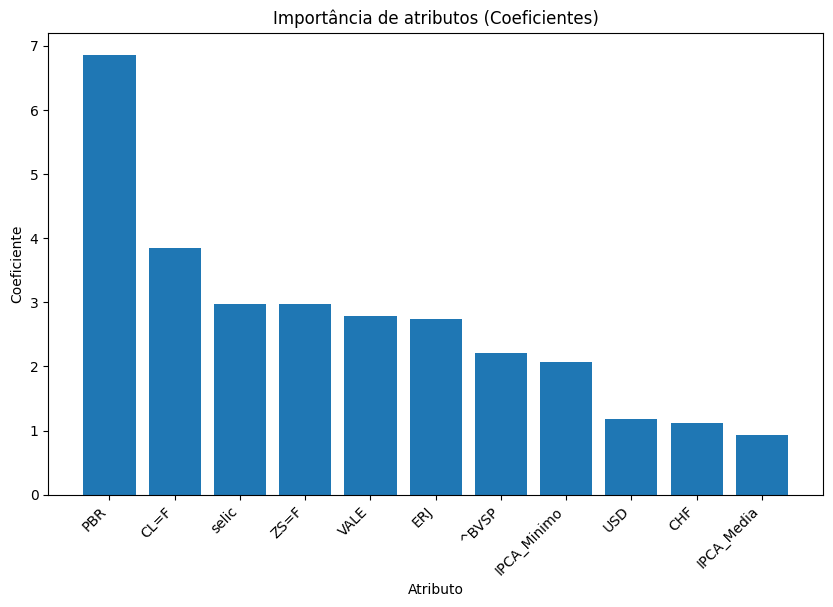

In [104]:
plot_feature_importance_knn(knn, X_train, X.columns)

### Experimento (3) - Regressão com Árvore de Decisão

#### Validação Cruzada

In [105]:
param_grid = {
    'criterion': ['friedman_mse', 'absolute_error', 'squared_error', 'poisson'],  # Splitting criterion
    'splitter': ['best', 'random'],               # Strategy used to choose the split at each node
    'max_depth': [None, 15, 20],           # Maximum depth of the tree
    'min_samples_split': [2, 5],               # Minimum number of samples required to split an internal node
    'min_samples_leaf': [1, 2],                 # Minimum number of samples required to be at a leaf node
    'max_features': ['sqrt', 'log2', None] # Number of features to consider when looking for the best split
}

tree_cv_results = []

for k in k_range:
    grid = GridSearchCV(DecisionTreeRegressor(), param_grid, cv=k, scoring=scoring, refit=False)
    grid.fit(X_train, y_train)
    tree_cv_results.append(grid)

    print(f"\nCV: {k}")
    print_regression_cv_metrics(grid.cv_results_)


CV: 3
Best Params: {'criterion': 'poisson', 'max_depth': 15, 'max_features': None, 'min_samples_leaf': 2, 'min_samples_split': 5, 'splitter': 'random'}
MAE: 13.8562 ± 0.7908
MSE: 511.0153 ± 94.5769
R2: 0.9993 ± 0.0001

CV: 4
Best Params: {'criterion': 'absolute_error', 'max_depth': None, 'max_features': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'splitter': 'random'}
MAE: 13.0671 ± 0.6741
MSE: 619.4311 ± 164.6571
R2: 0.9991 ± 0.0002

CV: 5
Best Params: {'criterion': 'poisson', 'max_depth': None, 'max_features': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'splitter': 'random'}
MAE: 12.3577 ± 1.1544
MSE: 477.2999 ± 145.4685
R2: 0.9993 ± 0.0002

CV: 6
Best Params: {'criterion': 'poisson', 'max_depth': 15, 'max_features': None, 'min_samples_leaf': 2, 'min_samples_split': 2, 'splitter': 'random'}
MAE: 12.3537 ± 0.4612
MSE: 493.3693 ± 94.4354
R2: 0.9993 ± 0.0001

CV: 7
Best Params: {'criterion': 'poisson', 'max_depth': None, 'max_features': None, 'min_samples_leaf': 1, 'm

Após a validação cruzada, o modelo de árvore de decisão obteve um MSE mais alto em relação ao KNN.

Como os resultados obtidos pela validação cruzada foram diversos, optamos por utilizar a moda para obter as melhores métricas.

In [106]:
best_tree_params = []

for result in tree_cv_results:
    best_index = result.cv_results_['mean_test_r2'].argmax()
    best_params = result.cv_results_['params'][best_index]
    best_tree_params.append(best_params)

In [107]:
best_params = {}

for param_name in best_tree_params[0].keys():
    param_values = [param[param_name] for param in best_tree_params]
    best_params[param_name] = Counter(param_values).most_common(1)[0][0]

best_params

{'criterion': 'poisson',
 'max_depth': None,
 'max_features': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'splitter': 'random'}

#### Avaliando para a base de testes e treino

In [108]:
dt = DecisionTreeRegressor(**best_params)

dt.fit(X_train, y_train)

y_pred = dt.predict(X_test)
y_pred_train = dt.predict(X_train)

print("===== Results for test =====")
print_regression_metrics(y_test, y_pred)
print()

print("===== Results for train =====")
print_regression_metrics(y_train, y_pred_train)
print()

===== Results for test =====
Mean Absolute Error (MAE): 9.6583
Mean Squared Error (MSE): 224.6103
Root Mean Squared Error (RMSE): 14.9870
R2-Score: 0.9997

===== Results for train =====
Mean Absolute Error (MAE): 0.0000
Mean Squared Error (MSE): 0.0000
Root Mean Squared Error (RMSE): 0.0000
R2-Score: 1.0000



In [109]:
normal_dt_pred = y_pred.copy()

Entretanto, neste caso, a MSE foi consideravelmente mais alta do que a MSE do KNN.

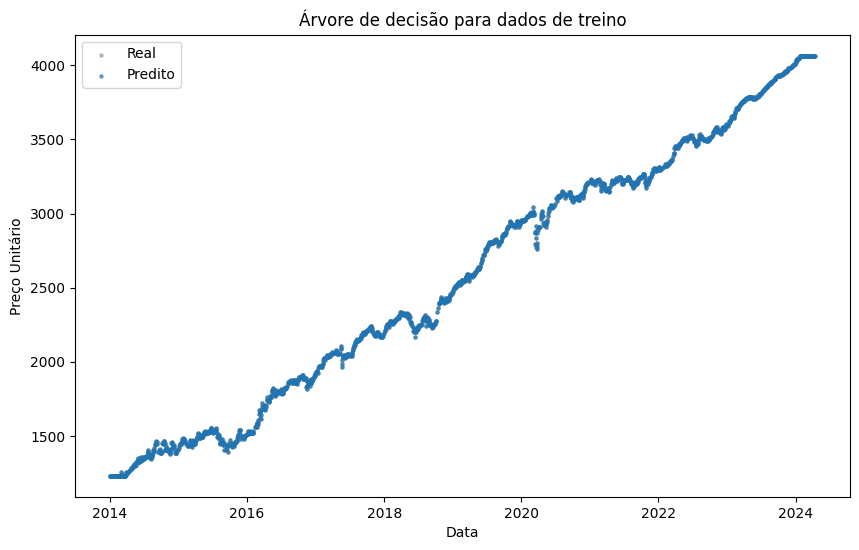

In [110]:
plot_regression_scatter(X_train, y_train, y_pred_train, title="Árvore de decisão para dados de treino")

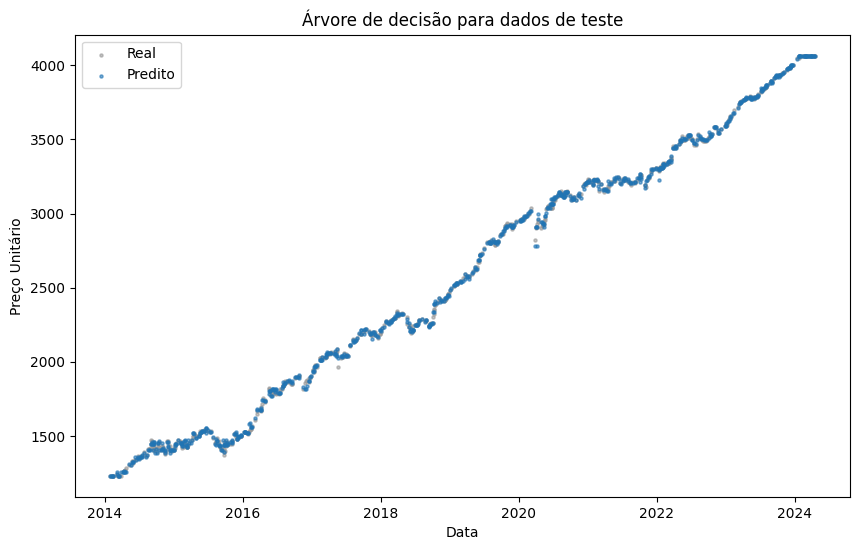

In [111]:
plot_regression_scatter(X_test, y_test, y_pred, title="Árvore de decisão para dados de teste")

#### Analisando a importância das features

Por sua vez, na árvore de decisão, o dólar assumiu um papel de grande importância.

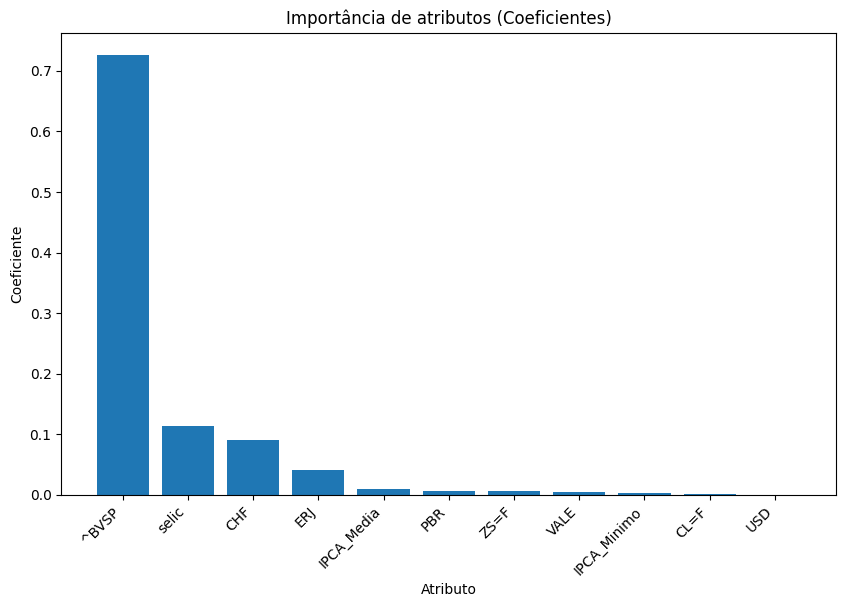

In [112]:
plot_feature_importance_dt(dt, X.columns)

### Experimento (4) e (5) - Regressão considerando os dados como uma série temporal com validação cruzada

#### Treino e Teste

Agora vamos realizar um corte temporal, onde os últimos 30% dos data points pertencerão ao conjunto de teste.

In [113]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=123, shuffle=False)
standard_scale(X_train, X_test, X_train.columns)

In [114]:
ts_y_test = y_test.copy()

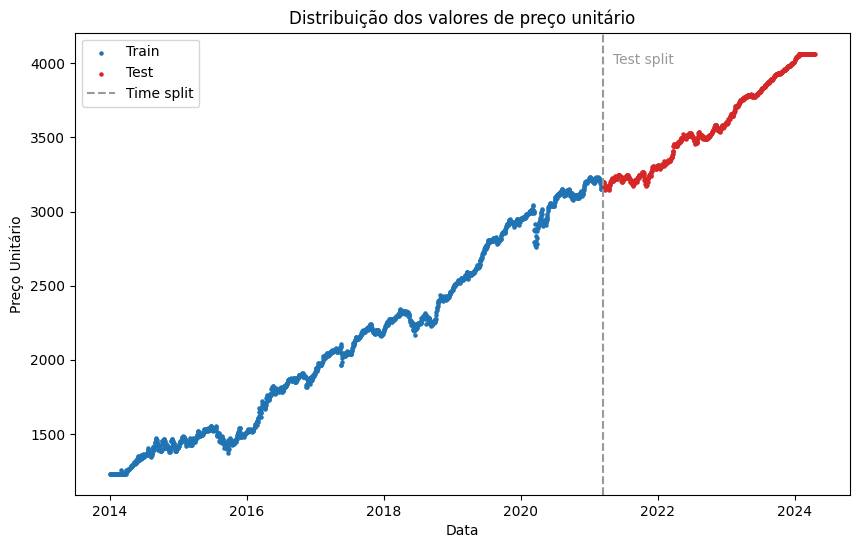

In [115]:
fig, ax = plt.subplots(figsize=(10, 6))

ax.scatter(y_train.index, y_train, color=colors['blue'], label='Train', s=5)

ax.scatter(y_test.index, y_test, color=colors['red'], label='Test', s=5)

ax.axvline(x=y_train.index[-1], color=colors['gray'], linestyle='--', label='Time split')

time_split_x = y_train.index[-1]
time_split_y = ax.get_ylim()[1] * 0.95
label_offset = pd.Timedelta(days=50)
ax.text(time_split_x + label_offset, time_split_y, 'Test split', color=colors['gray'])

ax.set_xlabel('Data')
ax.set_ylabel('Preço Unitário')
ax.set_title('Distribuição dos valores de preço unitário')
ax.legend()

plt.show()

In [116]:
time_series_data = df['PU Compra Manhã']

#### Time Series Split

Vamos visualizar como o TimesSeriesSplit divide os dados a cada iteração, tendo em vista que esses serão os folds utilizados para nossa validação cruzada.

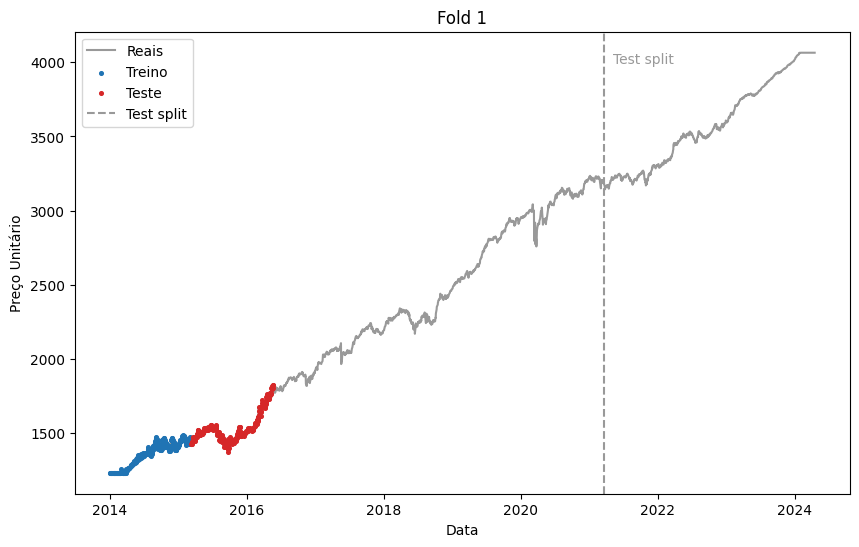

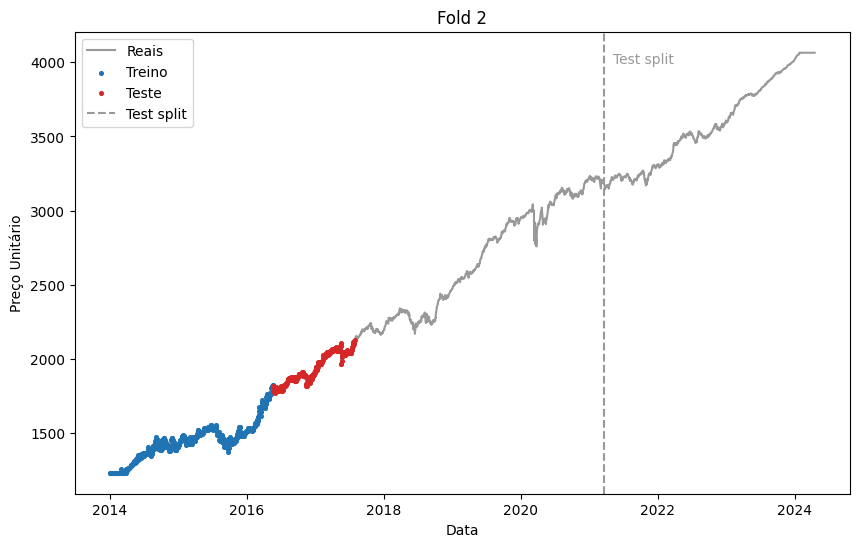

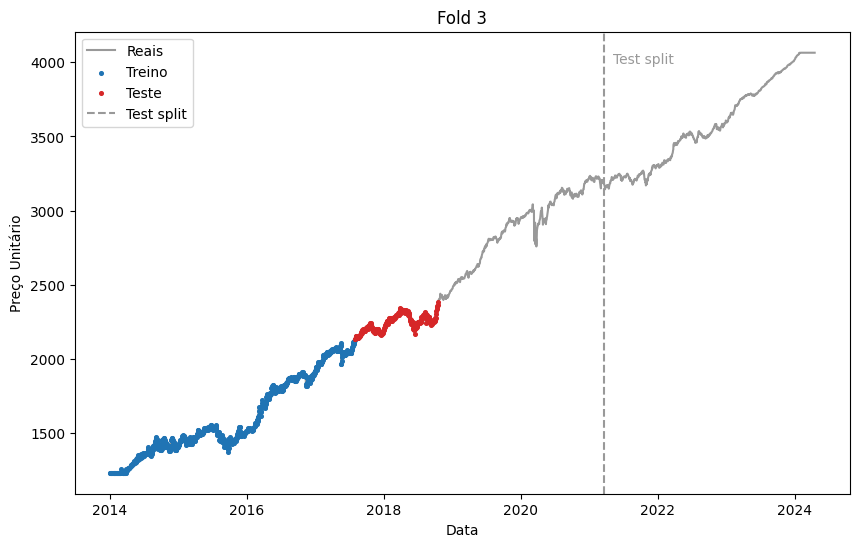

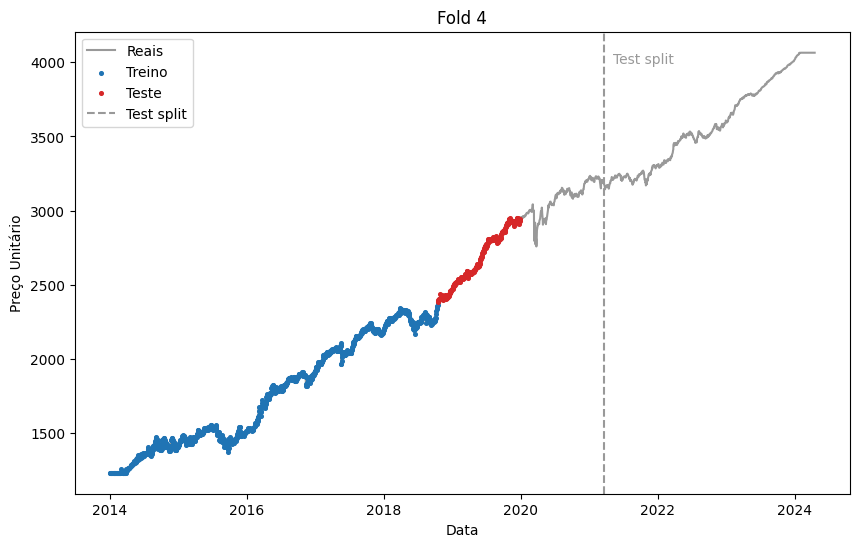

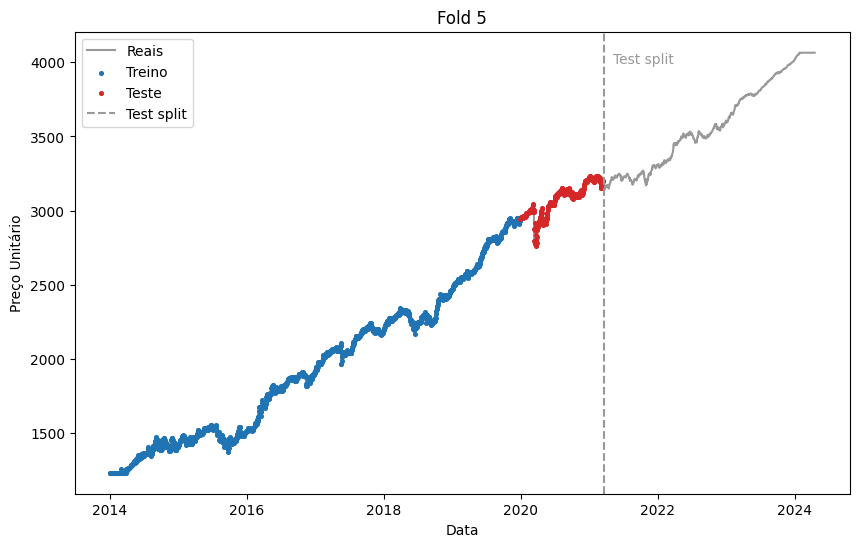

In [117]:
tss = TimeSeriesSplit()


for fold_index, (train_index, test_index) in enumerate(tss.split(X_train), start=1):
    fold_title = f'Fold {fold_index}'
    fig, ax = plt.subplots(figsize=(10, 6))
    
    ax.plot(df.index, y, color=colors['gray'], label='Reais', zorder=1)
    
    ax.scatter(df.index[train_index], y.iloc[train_index], color=colors['blue'], label='Treino', marker='o', s=7, zorder=2)
    
    ax.scatter(df.index[test_index], y.iloc[test_index], color=colors['red'], label='Teste', marker='o', s=7, zorder=2)

    ax.axvline(x=y_test.index[0], color=colors['gray'], linestyle='--', label='Test split')

    time_split_x = y_test.index[0]
    time_split_y = ax.get_ylim()[1] * 0.95
    label_offset = pd.Timedelta(days=50)
    ax.text(time_split_x + label_offset, time_split_y, 'Test split', color=colors['gray'])
    
    ax.set_xlabel('Data')
    ax.set_ylabel('Preço Unitário')
    ax.set_title(fold_title)
    
    ax.legend()
    
    plt.show()

#### Testes de Hipótese

Antes de continuarmos nossa modelagem, vamos entender como nossa série temporal se dá.

In [118]:
result = adfuller(time_series_data)

print('ADF Statistic:', result[0])
print('p-value:', result[1])
print('Critical Values:')
for key, value in result[4].items():
    print(f'\t{key}: {value}')

if result[1] < 0.05:
    print("Reject the null hypothesis (H0), the data is stationary.")
else:
    print("Fail to reject the null hypothesis (H0), the data is non-stationary.")

ADF Statistic: 0.24058695372015793
p-value: 0.9744482954340146
Critical Values:
	1%: -3.4329109857007527
	5%: -2.862671440775931
	10%: -2.5673723078962385
Fail to reject the null hypothesis (H0), the data is non-stationary.


Após realizar o teste de ADF Fuller, podemos perceber que temos uma série temporal não estacionária. Isto é, a média desta série temporal flutuam com o tempo.

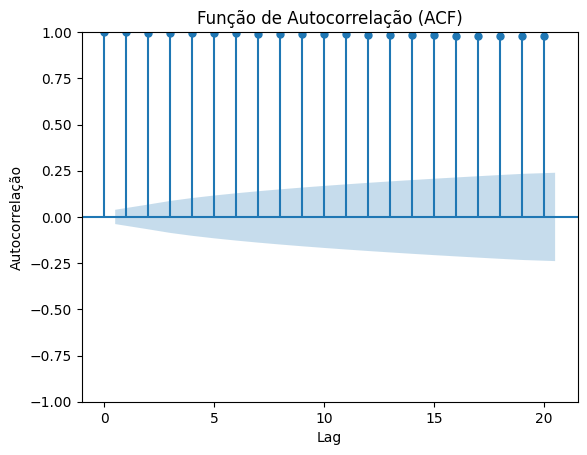

In [119]:
plot_acf(time_series_data, lags=20)
plt.title('Função de Autocorrelação (ACF)')
plt.xlabel('Lag')
plt.ylabel('Autocorrelação')
plt.show()

Podemos perceber neste gráfico, que a autocorrelação dos valores de preços unitários possuem uma correlação quase perfeita. Isto é, modelos que levem em consideração os valores anteriores podem obter resultados bons. Desta forma, levando em consideração que temos dados não estacionários com forte autocorrelação, podemos ter indícios de que talvez modelos AR com MA obtenham bons resultados. Será o ponto a ser explorado na seção de "Como o modelo poderia ser melhorado."

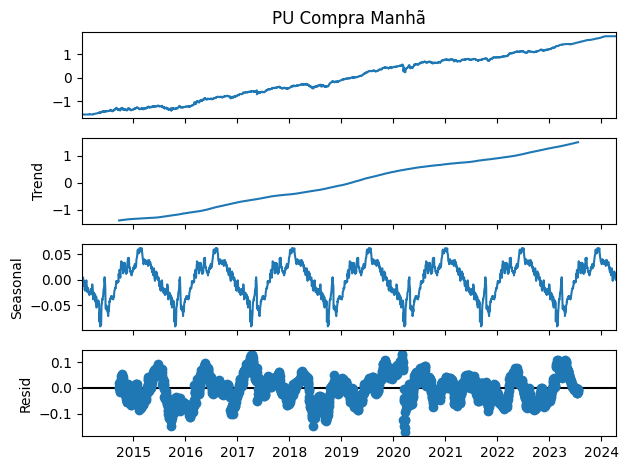

In [120]:
result = seasonal_decompose(df['PU Compra Manhã'], model='additive', period=365)
result.plot()
plt.show()

Bem, é possível perceber uma tendência muita forte, mas como se dá a sazonalidade?

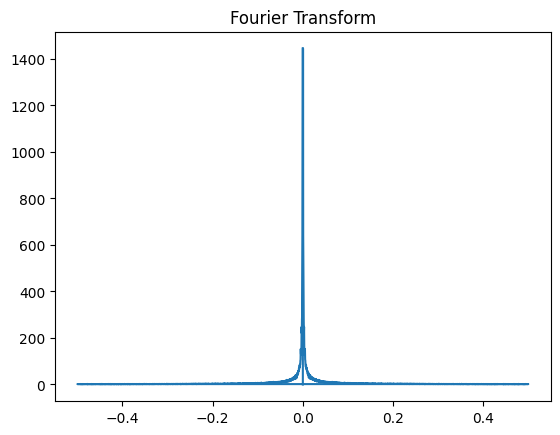

In [121]:
fft = np.fft.fft(df['PU Compra Manhã'])
frequencies = np.fft.fftfreq(len(fft))
plt.plot(frequencies, np.abs(fft))
plt.title('Fourier Transform')
plt.show()

Ao observar os resultados obtidos pelo Fourier Transform e o Periodograma, não encontramos indícios de sazonalidade. Desta forma, temos uma série temporal não estacionária e não-sazonal, com uma forte tendência. Desta forma, vamos observar, futuramente, como modelos de ARIMA, LSTM e o Prophet performam nessa série temporal, apesar do Prophet ser otimizado para séries com sazonalidade.

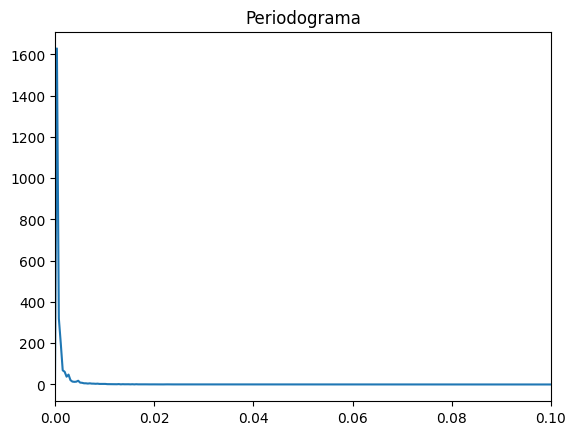

In [122]:
frequencies, spectrum = periodogram(df['PU Compra Manhã'])
plt.plot(frequencies, spectrum)
plt.title('Periodograma')
plt.xlim(0, 0.1)
plt.show()

#### 1 - Regressão Linear

##### Validação Cruzada

In [123]:
grid_search = GridSearchCV(LinearRegression(), linear_parameters, cv=tss, scoring=scoring, refit=False)
grid_search.fit(X_train, y_train)
best_index = print_regression_cv_metrics(grid_search.cv_results_)

Best Params: {'copy_X': True, 'fit_intercept': True}
MAE: 112.4985 ± 45.9858
MSE: 26077.7411 ± 19126.1484
R2: -2.2881 ± 2.1999


Agora que trocamos para séries temporais, os modelos anteriores provavelmente não performarão tão bem. Logo aqui, podemos perceber um R2 negativo e um MSE bem alto.

In [124]:
best_index = grid_search.cv_results_['mean_test_r2'].argmax()
linear_best_params = grid_search.cv_results_['params'][best_index]
linear_best_params

{'copy_X': True, 'fit_intercept': True}

##### Treino e Teste

In [125]:
model = LinearRegression(
    copy_X=linear_best_params['copy_X'],
    fit_intercept=linear_best_params['fit_intercept']
)

model.fit(X_train, y_train)

y_pred = model.predict(X_test)
y_pred_train = model.predict(X_train)

print("===== Results for test =====")
print_regression_metrics(y_test, y_pred)
print()

print("===== Results for train =====")
print_regression_metrics(y_train, y_pred_train)
print()

===== Results for test =====
Mean Absolute Error (MAE): 778.4277
Mean Squared Error (MSE): 707195.0124
Root Mean Squared Error (RMSE): 840.9489
R2-Score: -7.4149

===== Results for train =====
Mean Absolute Error (MAE): 42.8765
Mean Squared Error (MSE): 3036.1130
Root Mean Squared Error (RMSE): 55.1009
R2-Score: 0.9920



In [126]:
ts_lr_pred = y_pred.copy()

Os resultados para os dados de treino foram desastrosos. Vamos ver o gráfico para esses valores preditos:

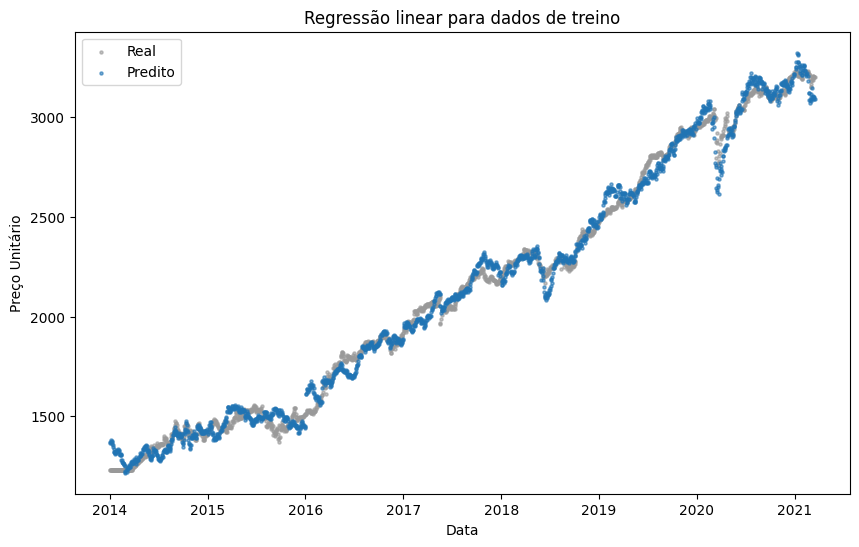

In [127]:
plot_regression_scatter(X_train, y_train, y_pred_train, title="Regressão linear para dados de treino")

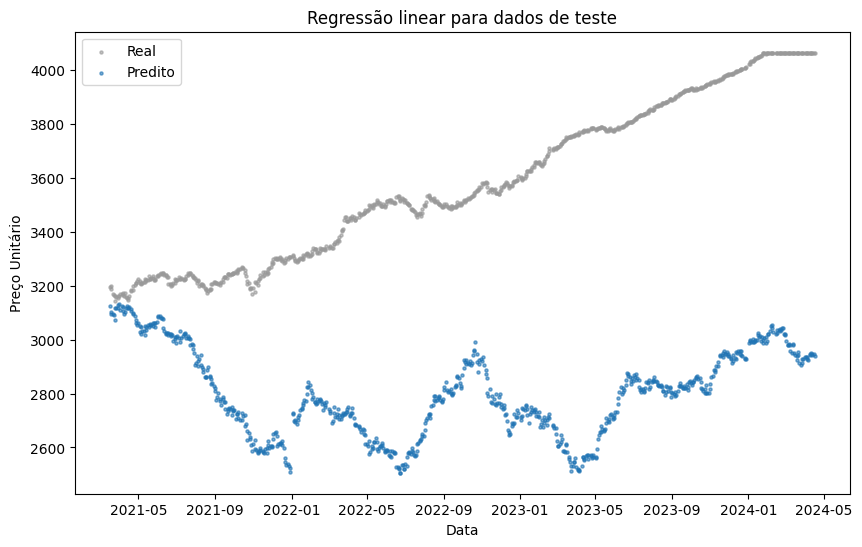

In [128]:
plot_regression_scatter(X_test, y_test, y_pred, title="Regressão linear para dados de teste")

Dessa forma, o modelo de regressão linear não conseguiu ir bem com os dados em forma de série temporal.

##### Importância de features

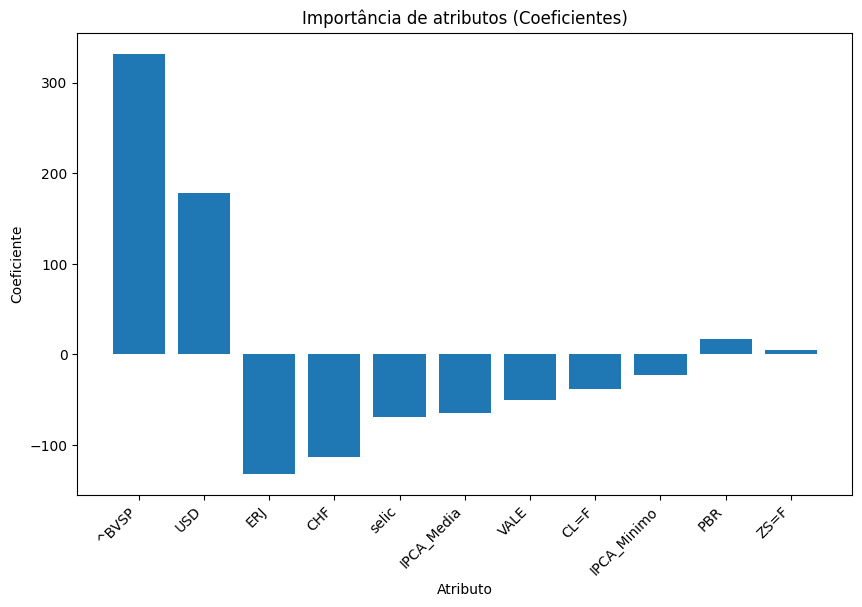

In [129]:
plot_feature_importance_linear(model, X.columns)

#### 2 - KNN

##### Validação Cruzada

Modelos que se baseiam nos valores dos atributos treinados, como o K-NN e Árvore de Decisão provavelmente não vão performar bem, falhando em capturar momentos de alta, uma vez que terão como base o que salvaram. Vamos ver isso na prática.

In [130]:
grid_search = GridSearchCV(KNeighborsRegressor(), knn_param_grid, cv=tss, scoring=scoring, refit=False)

grid_search.fit(X_train, y_train)

print_regression_cv_metrics(grid_search.cv_results_)

Best Params: {'metric': 'minkowski', 'n_neighbors': 8}
MAE: 223.8027 ± 86.6352
MSE: 77151.0867 ± 50081.3107
R2: -6.2481 ± 4.0089


In [131]:
best_index = grid_search.cv_results_['mean_test_r2'].argmax()
knn_best_params = grid_search.cv_results_['params'][best_index]
knn_best_params

{'metric': 'minkowski', 'n_neighbors': 8}

##### Treino e Teste

In [132]:
model = KNeighborsRegressor(
    metric=knn_best_params['metric'],
    n_neighbors=knn_best_params['n_neighbors']
)

model.fit(X_train, y_train)

y_pred = model.predict(X_test)
y_pred_train = model.predict(X_train)

print("===== Results for test =====")
print_regression_metrics(y_test, y_pred)
print()

print("===== Results for train =====")
print_regression_metrics(y_train, y_pred_train)
print()

===== Results for test =====
Mean Absolute Error (MAE): 394.9532
Mean Squared Error (MSE): 262972.9097
Root Mean Squared Error (RMSE): 512.8088
R2-Score: -2.1291

===== Results for train =====
Mean Absolute Error (MAE): 8.3673
Mean Squared Error (MSE): 163.7786
Root Mean Squared Error (RMSE): 12.7976
R2-Score: 0.9996



In [133]:
ts_knn_pred = y_pred.copy()

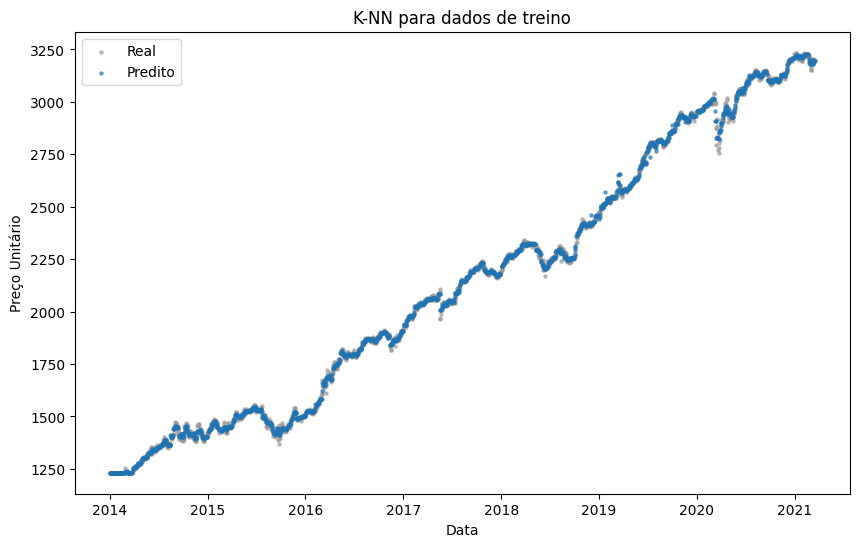

In [134]:
plot_regression_scatter(X_train, y_train, y_pred_train, title="K-NN para dados de treino")

Como é possível observar, o modelo está levando em consideração os valores observados na etapa de treino, e tentando posicionar os valores de teste em relação a eles, dessa forma falhando em capturar o crescimento da série temporal.

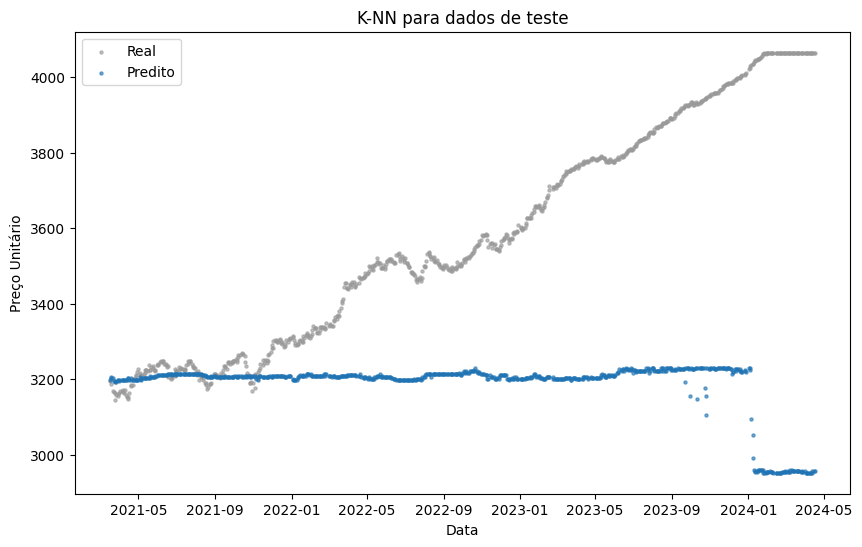

In [135]:
plot_regression_scatter(X_test, y_test, y_pred, title="K-NN para dados de teste")

##### Importância de features

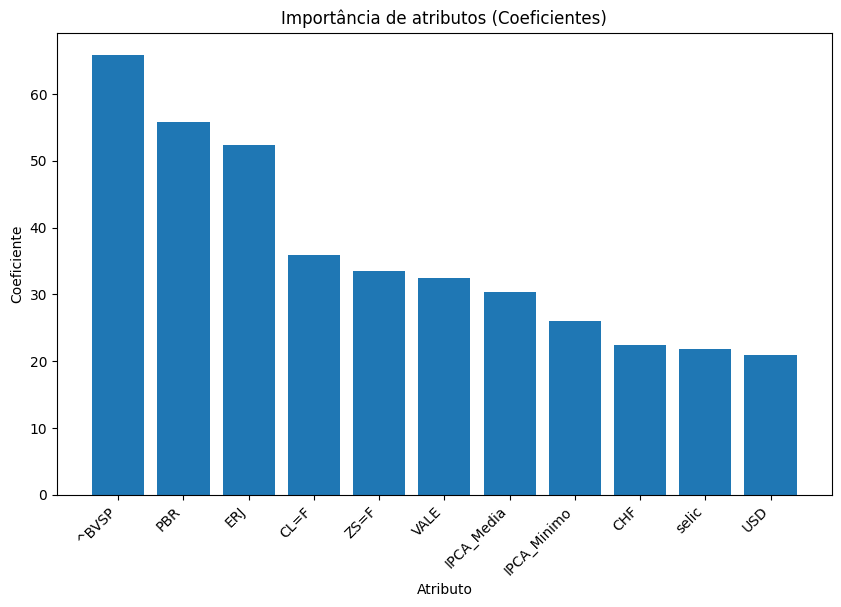

In [136]:
plot_feature_importance_knn(model, X_train, X.columns)

### Como o modelo poderia ser melhorado?

**Pontuação EXTRA: 20 pontos**


Indique nesta célula de texto como você poderia surgerir um melhor modelo de predição.

Obs: caso a análise seja condizente e melhore mesmo, e a dupla alcance 100 pontos, a pontuação poderá ir para outra prática.

Agora, vamos usar modelos específicos para a predição em cima de séries temporais.

#### Prophet

O Prophet é um bom modelo para predição de séries temporais devido à sua capacidade de lidar com feriados e tendências, além de ser fácil de usar e interpretar. Vamos ver como ele performa para a nossa série.

In [137]:
train_df = pd.DataFrame({'ds': y_train.index, 'y': y_train})

In [138]:
param_grid = {
    'changepoint_prior_scale': [0.001, 0.01, 0.1, 0.5],
    'seasonality_prior_scale': [0.01, 1.0],
    'seasonality_mode': ['additive', 'multiplicative']
}

grid = ParameterGrid(param_grid)

In [139]:
def train_prophet_model(train_df, params):
    model = Prophet(**params)
    model.fit(train_df)
    return model

Vamos também procurar os melhores parâmetros para o Prophet.

In [140]:
tscv = TimeSeriesSplit(n_splits=5)

best_params = None
best_mse = float('inf')

for params in grid:
    print(params)
    mse_scores = []

    for train_index, val_index in tscv.split(y_train):
        train_fold, val_fold = y_train.iloc[train_index], y_train.iloc[val_index]

        train_df_fold = pd.DataFrame({'ds': train_fold.index, 'y': train_fold.values})

        model = train_prophet_model(train_df_fold, params)

        forecast = model.predict(pd.DataFrame({'ds': val_fold.index}))

        mse_fold = mean_squared_error(val_fold, forecast['yhat'])
        mse_scores.append(mse_fold)

    avg_mse = np.mean(mse_scores)

    if avg_mse < best_mse:
        best_params = params
        best_mse = avg_mse

print("Best Hyperparameters:", best_params)
print("Best Average MSE:", best_mse)


19:19:23 - cmdstanpy - INFO - Chain [1] start processing
19:19:23 - cmdstanpy - INFO - Chain [1] done processing


{'changepoint_prior_scale': 0.001, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.01}


19:19:23 - cmdstanpy - INFO - Chain [1] start processing
19:19:24 - cmdstanpy - INFO - Chain [1] done processing
19:19:24 - cmdstanpy - INFO - Chain [1] start processing
19:19:24 - cmdstanpy - INFO - Chain [1] done processing
19:19:24 - cmdstanpy - INFO - Chain [1] start processing
19:19:24 - cmdstanpy - INFO - Chain [1] done processing
19:19:24 - cmdstanpy - INFO - Chain [1] start processing
19:19:24 - cmdstanpy - INFO - Chain [1] done processing
19:19:24 - cmdstanpy - INFO - Chain [1] start processing
19:19:24 - cmdstanpy - INFO - Chain [1] done processing


{'changepoint_prior_scale': 0.001, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 1.0}


19:19:25 - cmdstanpy - INFO - Chain [1] start processing
19:19:25 - cmdstanpy - INFO - Chain [1] done processing
19:19:25 - cmdstanpy - INFO - Chain [1] start processing
19:19:25 - cmdstanpy - INFO - Chain [1] done processing
19:19:25 - cmdstanpy - INFO - Chain [1] start processing
19:19:25 - cmdstanpy - INFO - Chain [1] done processing
19:19:25 - cmdstanpy - INFO - Chain [1] start processing
19:19:25 - cmdstanpy - INFO - Chain [1] done processing
19:19:25 - cmdstanpy - INFO - Chain [1] start processing
19:19:25 - cmdstanpy - INFO - Chain [1] done processing


{'changepoint_prior_scale': 0.001, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.01}


19:19:26 - cmdstanpy - INFO - Chain [1] start processing
19:19:26 - cmdstanpy - INFO - Chain [1] done processing
19:19:26 - cmdstanpy - INFO - Chain [1] start processing
19:19:26 - cmdstanpy - INFO - Chain [1] done processing
19:19:26 - cmdstanpy - INFO - Chain [1] start processing
19:19:26 - cmdstanpy - INFO - Chain [1] done processing
19:19:26 - cmdstanpy - INFO - Chain [1] start processing
19:19:26 - cmdstanpy - INFO - Chain [1] done processing
19:19:27 - cmdstanpy - INFO - Chain [1] start processing
19:19:27 - cmdstanpy - INFO - Chain [1] done processing


{'changepoint_prior_scale': 0.001, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 1.0}


19:19:27 - cmdstanpy - INFO - Chain [1] start processing
19:19:27 - cmdstanpy - INFO - Chain [1] done processing
19:19:27 - cmdstanpy - INFO - Chain [1] start processing
19:19:27 - cmdstanpy - INFO - Chain [1] done processing
19:19:27 - cmdstanpy - INFO - Chain [1] start processing
19:19:27 - cmdstanpy - INFO - Chain [1] done processing
19:19:27 - cmdstanpy - INFO - Chain [1] start processing
19:19:27 - cmdstanpy - INFO - Chain [1] done processing
19:19:28 - cmdstanpy - INFO - Chain [1] start processing
19:19:28 - cmdstanpy - INFO - Chain [1] done processing


{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.01}


19:19:28 - cmdstanpy - INFO - Chain [1] start processing
19:19:28 - cmdstanpy - INFO - Chain [1] done processing
19:19:28 - cmdstanpy - INFO - Chain [1] start processing
19:19:28 - cmdstanpy - INFO - Chain [1] done processing
19:19:28 - cmdstanpy - INFO - Chain [1] start processing
19:19:28 - cmdstanpy - INFO - Chain [1] done processing
19:19:29 - cmdstanpy - INFO - Chain [1] start processing
19:19:29 - cmdstanpy - INFO - Chain [1] done processing
19:19:29 - cmdstanpy - INFO - Chain [1] start processing
19:19:29 - cmdstanpy - INFO - Chain [1] done processing


{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 1.0}


19:19:29 - cmdstanpy - INFO - Chain [1] start processing
19:19:29 - cmdstanpy - INFO - Chain [1] done processing
19:19:29 - cmdstanpy - INFO - Chain [1] start processing
19:19:29 - cmdstanpy - INFO - Chain [1] done processing
19:19:30 - cmdstanpy - INFO - Chain [1] start processing
19:19:30 - cmdstanpy - INFO - Chain [1] done processing
19:19:30 - cmdstanpy - INFO - Chain [1] start processing
19:19:30 - cmdstanpy - INFO - Chain [1] done processing
19:19:30 - cmdstanpy - INFO - Chain [1] start processing
19:19:30 - cmdstanpy - INFO - Chain [1] done processing


{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.01}


19:19:30 - cmdstanpy - INFO - Chain [1] start processing
19:19:30 - cmdstanpy - INFO - Chain [1] done processing
19:19:31 - cmdstanpy - INFO - Chain [1] start processing
19:19:31 - cmdstanpy - INFO - Chain [1] done processing
19:19:31 - cmdstanpy - INFO - Chain [1] start processing
19:19:31 - cmdstanpy - INFO - Chain [1] done processing
19:19:31 - cmdstanpy - INFO - Chain [1] start processing
19:19:31 - cmdstanpy - INFO - Chain [1] done processing
19:19:32 - cmdstanpy - INFO - Chain [1] start processing
19:19:32 - cmdstanpy - INFO - Chain [1] done processing


{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 1.0}


19:19:32 - cmdstanpy - INFO - Chain [1] start processing
19:19:32 - cmdstanpy - INFO - Chain [1] done processing
19:19:32 - cmdstanpy - INFO - Chain [1] start processing
19:19:32 - cmdstanpy - INFO - Chain [1] done processing
19:19:33 - cmdstanpy - INFO - Chain [1] start processing
19:19:34 - cmdstanpy - INFO - Chain [1] done processing
19:19:34 - cmdstanpy - INFO - Chain [1] start processing
19:19:35 - cmdstanpy - INFO - Chain [1] done processing
19:19:35 - cmdstanpy - INFO - Chain [1] start processing
19:19:35 - cmdstanpy - INFO - Chain [1] done processing


{'changepoint_prior_scale': 0.1, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.01}


19:19:35 - cmdstanpy - INFO - Chain [1] start processing
19:19:36 - cmdstanpy - INFO - Chain [1] done processing
19:19:36 - cmdstanpy - INFO - Chain [1] start processing
19:19:36 - cmdstanpy - INFO - Chain [1] done processing
19:19:36 - cmdstanpy - INFO - Chain [1] start processing
19:19:37 - cmdstanpy - INFO - Chain [1] done processing
19:19:37 - cmdstanpy - INFO - Chain [1] start processing
19:19:37 - cmdstanpy - INFO - Chain [1] done processing
19:19:38 - cmdstanpy - INFO - Chain [1] start processing
19:19:38 - cmdstanpy - INFO - Chain [1] done processing


{'changepoint_prior_scale': 0.1, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 1.0}


19:19:38 - cmdstanpy - INFO - Chain [1] start processing
19:19:38 - cmdstanpy - INFO - Chain [1] done processing
19:19:38 - cmdstanpy - INFO - Chain [1] start processing
19:19:39 - cmdstanpy - INFO - Chain [1] done processing
19:19:39 - cmdstanpy - INFO - Chain [1] start processing
19:19:39 - cmdstanpy - INFO - Chain [1] done processing
19:19:39 - cmdstanpy - INFO - Chain [1] start processing
19:19:40 - cmdstanpy - INFO - Chain [1] done processing
19:19:40 - cmdstanpy - INFO - Chain [1] start processing
19:19:40 - cmdstanpy - INFO - Chain [1] done processing


{'changepoint_prior_scale': 0.1, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.01}


19:19:40 - cmdstanpy - INFO - Chain [1] start processing
19:19:41 - cmdstanpy - INFO - Chain [1] done processing
19:19:41 - cmdstanpy - INFO - Chain [1] start processing
19:19:41 - cmdstanpy - INFO - Chain [1] done processing
19:19:41 - cmdstanpy - INFO - Chain [1] start processing
19:19:42 - cmdstanpy - INFO - Chain [1] done processing
19:19:42 - cmdstanpy - INFO - Chain [1] start processing
19:19:42 - cmdstanpy - INFO - Chain [1] done processing
19:19:42 - cmdstanpy - INFO - Chain [1] start processing


{'changepoint_prior_scale': 0.1, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 1.0}


19:19:43 - cmdstanpy - INFO - Chain [1] done processing
19:19:43 - cmdstanpy - INFO - Chain [1] start processing
19:19:43 - cmdstanpy - INFO - Chain [1] done processing
19:19:43 - cmdstanpy - INFO - Chain [1] start processing
19:19:44 - cmdstanpy - INFO - Chain [1] done processing
19:19:44 - cmdstanpy - INFO - Chain [1] start processing
19:19:45 - cmdstanpy - INFO - Chain [1] done processing
19:19:45 - cmdstanpy - INFO - Chain [1] start processing
19:19:46 - cmdstanpy - INFO - Chain [1] done processing
19:19:47 - cmdstanpy - INFO - Chain [1] start processing


{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.01}


19:19:47 - cmdstanpy - INFO - Chain [1] done processing
19:19:47 - cmdstanpy - INFO - Chain [1] start processing
19:19:47 - cmdstanpy - INFO - Chain [1] done processing
19:19:47 - cmdstanpy - INFO - Chain [1] start processing
19:19:48 - cmdstanpy - INFO - Chain [1] done processing
19:19:48 - cmdstanpy - INFO - Chain [1] start processing
19:19:48 - cmdstanpy - INFO - Chain [1] done processing
19:19:48 - cmdstanpy - INFO - Chain [1] start processing
19:19:49 - cmdstanpy - INFO - Chain [1] done processing
19:19:49 - cmdstanpy - INFO - Chain [1] start processing
19:19:49 - cmdstanpy - INFO - Chain [1] done processing


{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 1.0}


19:19:49 - cmdstanpy - INFO - Chain [1] start processing
19:19:49 - cmdstanpy - INFO - Chain [1] done processing
19:19:50 - cmdstanpy - INFO - Chain [1] start processing
19:19:50 - cmdstanpy - INFO - Chain [1] done processing
19:19:50 - cmdstanpy - INFO - Chain [1] start processing
19:19:51 - cmdstanpy - INFO - Chain [1] done processing
19:19:51 - cmdstanpy - INFO - Chain [1] start processing
19:19:51 - cmdstanpy - INFO - Chain [1] done processing
19:19:51 - cmdstanpy - INFO - Chain [1] start processing
19:19:52 - cmdstanpy - INFO - Chain [1] done processing


{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.01}


19:19:52 - cmdstanpy - INFO - Chain [1] start processing
19:19:52 - cmdstanpy - INFO - Chain [1] done processing
19:19:52 - cmdstanpy - INFO - Chain [1] start processing
19:19:52 - cmdstanpy - INFO - Chain [1] done processing
19:19:52 - cmdstanpy - INFO - Chain [1] start processing
19:19:53 - cmdstanpy - INFO - Chain [1] done processing
19:19:53 - cmdstanpy - INFO - Chain [1] start processing
19:19:54 - cmdstanpy - INFO - Chain [1] done processing
19:19:54 - cmdstanpy - INFO - Chain [1] start processing
19:19:54 - cmdstanpy - INFO - Chain [1] done processing


{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 1.0}


19:19:54 - cmdstanpy - INFO - Chain [1] start processing
19:19:54 - cmdstanpy - INFO - Chain [1] done processing
19:19:55 - cmdstanpy - INFO - Chain [1] start processing
19:19:55 - cmdstanpy - INFO - Chain [1] done processing
19:19:55 - cmdstanpy - INFO - Chain [1] start processing
19:19:55 - cmdstanpy - INFO - Chain [1] done processing
19:19:56 - cmdstanpy - INFO - Chain [1] start processing
19:19:56 - cmdstanpy - INFO - Chain [1] done processing


Best Hyperparameters: {'changepoint_prior_scale': 0.001, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.01}
Best Average MSE: 18010.649732583457


In [141]:
model = Prophet(**best_params)

model.fit(train_df)

future = model.make_future_dataframe(periods=len(y_test))
forecast = model.predict(future)

test_predictions = forecast[-len(y_test):]

19:19:56 - cmdstanpy - INFO - Chain [1] start processing
19:19:56 - cmdstanpy - INFO - Chain [1] done processing


Visualmente, temos uma grande melhora em relação aos modelos anteriores, mas como ficaram nossas métricas?

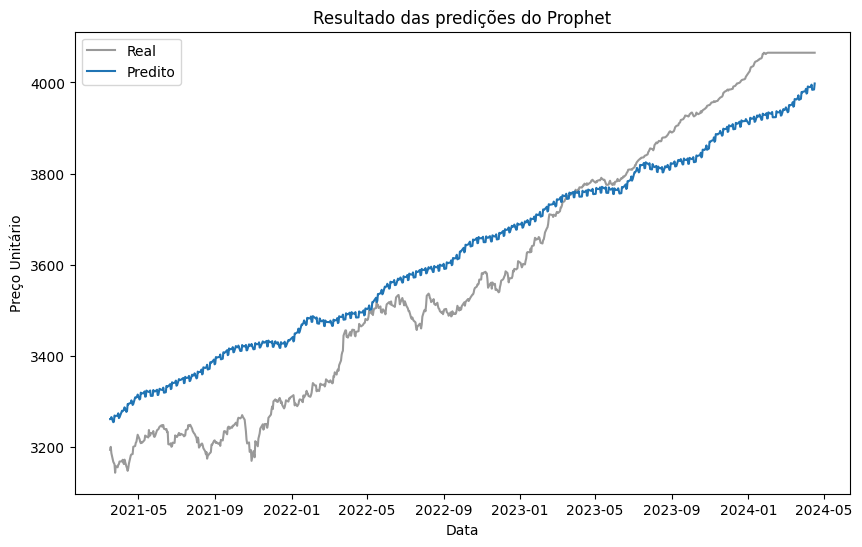

In [142]:
plot_data_Prophet = pd.DataFrame({'Date': y_test.index, 'Actual': y_test.values, 'Predicted': test_predictions['yhat']})

plot_data_Prophet = plot_data_Prophet.melt(id_vars='Date', var_name='Type', value_name='Value')

plt.figure(figsize=(10, 6))

plt.plot(plot_data_Prophet[plot_data_Prophet['Type'] == 'Actual']['Date'], 
         plot_data_Prophet[plot_data_Prophet['Type'] == 'Actual']['Value'], 
         color=colors['gray'], label='Real')

plt.plot(plot_data_Prophet[plot_data_Prophet['Type'] == 'Predicted']['Date'], 
         plot_data_Prophet[plot_data_Prophet['Type'] == 'Predicted']['Value'], 
         color=colors['blue'], label='Predito')

plt.title('Resultado das predições do Prophet')
plt.xlabel('Data')
plt.ylabel('Preço Unitário')
plt.legend()
plt.show()

In [143]:
ts_prophet_pred = test_predictions['yhat'].copy()

In [144]:
print_regression_metrics(actual=y_test, predicted=test_predictions['yhat'])

Mean Absolute Error (MAE): 92.7717
Mean Squared Error (MSE): 11168.8439
Root Mean Squared Error (RMSE): 105.6828
R2-Score: 0.8671


Temos uma melhoria considerável em relação aos modelos anteriores. O MSE ainda é alto, e o R2 possui espaço para melhora.

#### ARIMA

Por estarmos lidando com uma série temporal não estacionária, consideramos interessante realizar um modelo utilizando ARIMA, pois oferece simplicidade, capacidade de capturar tendências, além de flexibilidade para lidar com diferentes padrões de dados temporais.

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=14217.498, Time=0.41 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=14239.740, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=14213.391, Time=0.04 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=14212.001, Time=0.13 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=14250.831, Time=0.02 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=14213.509, Time=0.18 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=14213.543, Time=0.28 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=14208.935, Time=0.58 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=14210.423, Time=0.74 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=14215.542, Time=0.35 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=14207.841, Time=0.66 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=14213.603, Time=0.14 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=14217.601, Time=0.23 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=14215.589, Time=0.18 sec
 ARIMA(3,1,2)(0,0,0

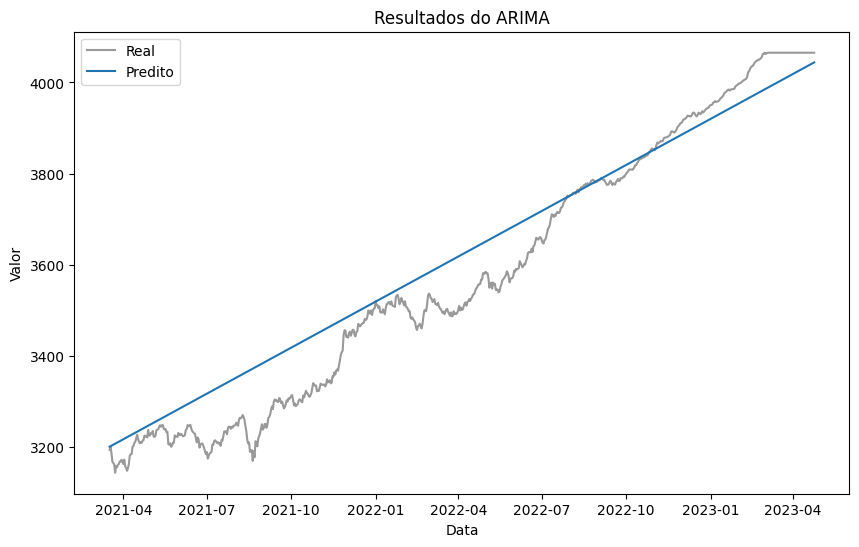

In [145]:
new_index_train = pd.date_range(start=y_train.index[0], periods=len(y_train), freq='D')
new_index_test = pd.date_range(start=y_test.index[0], periods=len(y_test), freq='D')

y_train.index = new_index_train
y_test.index = new_index_test

model = pm.auto_arima(y_train, seasonal=False, trace=True, error_action='ignore', suppress_warnings=True)
fit_model = model.fit(y_train)

forecast = fit_model.predict(n_periods=len(y_test))

actual_df = pd.DataFrame({'Date': y_test.index, 'Value': y_test.values, 'Type': 'Real'})
forecast_df = pd.DataFrame({'Date': y_test.index, 'Value': forecast, 'Type': 'Predito'})

plot_data_arima = pd.concat([actual_df, forecast_df])

plt.figure(figsize=(10, 6))

plt.plot(actual_df['Date'], actual_df['Value'], label='Real', color=colors['gray'])

plt.plot(forecast_df['Date'], forecast_df['Value'], label='Predito', color=colors['blue'])

plt.xlabel('Data')
plt.ylabel('Valor')
plt.title('Resultados do ARIMA')

plt.legend()

plt.show()

Visualmente, os valores preditos foram bem simples, uma linha reta, mesmo com os melhores parâmetros que pudemos encontrar. Mas isso foi melhor ou não do que o Prophet?

In [146]:
ts_arima_pred = forecast.copy()

In [147]:
print_regression_metrics(actual=y_test, predicted=forecast)

Mean Absolute Error (MAE): 61.6773
Mean Squared Error (MSE): 5676.7539
Root Mean Squared Error (RMSE): 75.3442
R2-Score: 0.9325


Obtivemos um R2 Score mais alto e um MSE menor. o ARIMA foi o melhor modelo para explicar a nossa série temporal.

### Conclusão   

Para finalizar, consideramos relevante fazer uma análise comparativa entre os modelos de regressão linear, KNN, Prophet, e ARIMA. Vamos separar em como os dados performaram sem considerar séries temporais e depois considerando séries temporais.

#### Resultados

##### Funções úteis

In [148]:
def create_table_data(
    test: pd.Series,
    results: dict[str, list]
):
    table_data = []

    for key, predicted in results.items():
        metrics = {
            "R²": r2_score(test, predicted),
            "MSE": mean_squared_error(test, predicted),
            "MAE": mean_absolute_error(test, predicted),
            "RMSE": np.sqrt(mean_squared_error(test, predicted))
        }
        row = [key] + list(metrics.values())
        table_data.append(row)
    
    return table_data

In [149]:
def get_table_colums() -> list[str]:
    return ["Modelo", "R²", "MSE", "MAE", "RMSE"]

In [150]:
def apply_gt_style(gt: GT) -> GT:
    gt.fmt_number(columns=["MAE", "MSE", "RMSE"], decimals=1)
    gt.fmt_number(columns="R²", decimals=4)
    gt.opt_stylize(style = 1, color = "blue")
    gt.opt_all_caps()
    gt.opt_vertical_padding(scale=1)
    gt.opt_horizontal_padding(scale=3)
    return gt

##### Sem considerar séries temporais 

In [151]:
results = {
    "Regressão Linear": normal_lr_pred,
    "K-NN": normal_knn_pred,
    "Árvore de Decisão": normal_dt_pred
}

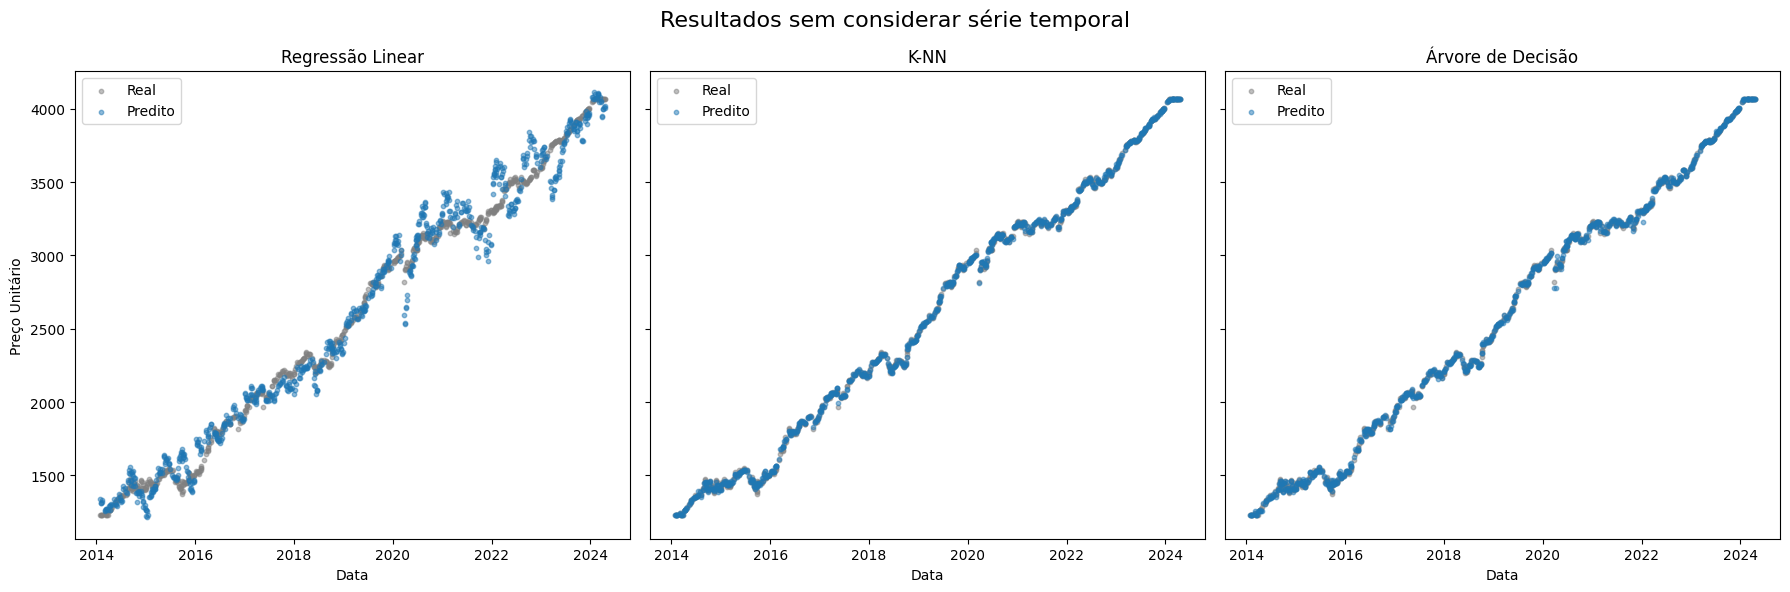

In [152]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(18, 6), sharey=True)

fig.suptitle('Resultados sem considerar série temporal', fontsize=16)

for ax, (key, predicted) in zip(axes, results.items()):
    ax.scatter(normal_y_test.index, normal_y_test, label='Real', color='grey', alpha=0.5, s=10)
    ax.scatter(normal_y_test.index, predicted, label='Predito', alpha=0.5, s=10)
    ax.legend()
    ax.set_title(f'{key}', fontsize=12)
    ax.set_xlabel('Data')

axes[0].set_ylabel('Preço Unitário')

plt.tight_layout()
plt.show()

In [153]:
normal_res_df = pd.DataFrame(create_table_data(normal_y_test, results), columns=get_table_colums())

gt = (
    GT(normal_res_df)
    .tab_header("Resultados sem considerar série temporal")
    .opt_all_caps()
    .opt_vertical_padding(scale=1.5)
    .opt_horizontal_padding(scale=3)
    .fmt_number(columns=["MAE", "MSE", "RMSE"], decimals=1)
    .fmt_number(columns="R²", decimals=4)
    .data_color(
        columns=["MSE"],
        palette=["rebeccapurple", "orange"],
        domain=[0, 15_000],
        na_color="white"
    )
    .data_color(
        columns=["MAE", "RMSE"],
        palette=["rebeccapurple", "orange"],
        domain=[0, 120],
        na_color="white"
    )
    .data_color(
        columns=["R²"],
        palette=["rebeccapurple", "orange"],
        domain=[1, 0],
        na_color="white"
    )
)

gt

GT(_tbl_data=              Modelo        R²           MSE        MAE        RMSE
0   Regressão Linear  0.981622  13538.895382  88.250041  116.356759
1               K-NN  0.999828    126.842073   7.668388   11.262419
2  Árvore de Decisão  0.999695    224.610312   9.658349   14.987005, _body=<great_tables._gt_data.Body object at 0x00000219C8BA9130>, _boxhead=Boxhead([ColInfo(var='Modelo', type=<ColInfoTypeEnum.default: 1>, column_label='Modelo', column_align='left', column_width=None), ColInfo(var='R²', type=<ColInfoTypeEnum.default: 1>, column_label='R²', column_align='right', column_width=None), ColInfo(var='MSE', type=<ColInfoTypeEnum.default: 1>, column_label='MSE', column_align='right', column_width=None), ColInfo(var='MAE', type=<ColInfoTypeEnum.default: 1>, column_label='MAE', column_align='right', column_width=None), ColInfo(var='RMSE', type=<ColInfoTypeEnum.default: 1>, column_label='RMSE', column_align='right', column_width=None)]), _stub=Stub([RowInfo(rownum_i=0, group_id=None, rowname=None, group_label=None, built=False), RowInfo(rownum_i=1, group_id=None, rowname=None, group_label=None, built=False), RowInfo(rownum_i=2, group_id=None, rowname=None, group_label=None, built=False)]), _row_groups=[], _group_rows=GroupRows([]), _spanners=Spanners([]), _heading=Heading(title='Resultados sem considerar série temporal', subtitle=None, preheader=None), _stubhead=None, _source_notes=[], _footnotes=[], _styles=[StyleInfo(locname='data', locnum=5, grpname=None, colname='MSE', rownum=0, colnum=None, styles=[CellStyleText(color='#000000', font=None, size=None, align=None, v_align=None, style=None, weight=None, stretch=None, decorate=None, transform=None, whitespace=None), CellStyleFill(color='#f09a0f')]), StyleInfo(locname='data', locnum=5, grpname=None, colname='MSE', rownum=1, colnum=None, styles=[CellStyleText(color='#FFFFFF', font=None, size=None, align=None, v_align=None, style=None, weight=None, stretch=None, decorate=None, transform=None, whitespace=None), CellStyleFill(color='#673498')]), StyleInfo(locname='data', locnum=5, grpname=None, colname='MSE', rownum=2, colnum=None, styles=[CellStyleText(color='#FFFFFF', font=None, size=None, align=None, v_align=None, style=None, weight=None, stretch=None, decorate=None, transform=None, whitespace=None), CellStyleFill(color='#683597')]), StyleInfo(locname='data', locnum=5, grpname=None, colname='MAE', rownum=0, colnum=None, styles=[CellStyleText(color='#000000', font=None, size=None, align=None, v_align=None, style=None, weight=None, stretch=None, decorate=None, transform=None, whitespace=None), CellStyleFill(color='#d78728')]), StyleInfo(locname='data', locnum=5, grpname=None, colname='MAE', rownum=1, colnum=None, styles=[CellStyleText(color='#FFFFFF', font=None, size=None, align=None, v_align=None, style=None, weight=None, stretch=None, decorate=None, transform=None, whitespace=None), CellStyleFill(color='#703a8f')]), StyleInfo(locname='data', locnum=5, grpname=None, colname='MAE', rownum=2, colnum=None, styles=[CellStyleText(color='#FFFFFF', font=None, size=None, align=None, v_align=None, style=None, weight=None, stretch=None, decorate=None, transform=None, whitespace=None), CellStyleFill(color='#723c8d')]), StyleInfo(locname='data', locnum=5, grpname=None, colname='RMSE', rownum=0, colnum=None, styles=[CellStyleText(color='#000000', font=None, size=None, align=None, v_align=None, style=None, weight=None, stretch=None, decorate=None, transform=None, whitespace=None), CellStyleFill(color='#faa205')]), StyleInfo(locname='data', locnum=5, grpname=None, colname='RMSE', rownum=1, colnum=None, styles=[CellStyleText(color='#FFFFFF', font=None, size=None, align=None, v_align=None, style=None, weight=None, stretch=None, decorate=None, transform=None, whitespace=None), CellStyleFill(color='#743e8b')]), StyleInfo(locname='data', locnum=5, grpname=None, colname='RMSE', rownum=2, colnum=None, styles=[CellStyleText(color='#FFFFFF', font=None, size=None, align=None, v_align=None, style=Non

Quando não levamos em consideração as séries temporais, o K-NN se apresentou como o melhor resultado, tendo em vista que seu erro médio foi consideravelmente menor do que a árvore de decisão, enquanto a regressão linear possui um erro muito alto

##### Considerando séries temporais

In [154]:
results = {
    "Regressão Linear": ts_lr_pred,
    "K-NN": ts_knn_pred,
    "Prophet": ts_prophet_pred,
    "ARIMA": ts_arima_pred,
}

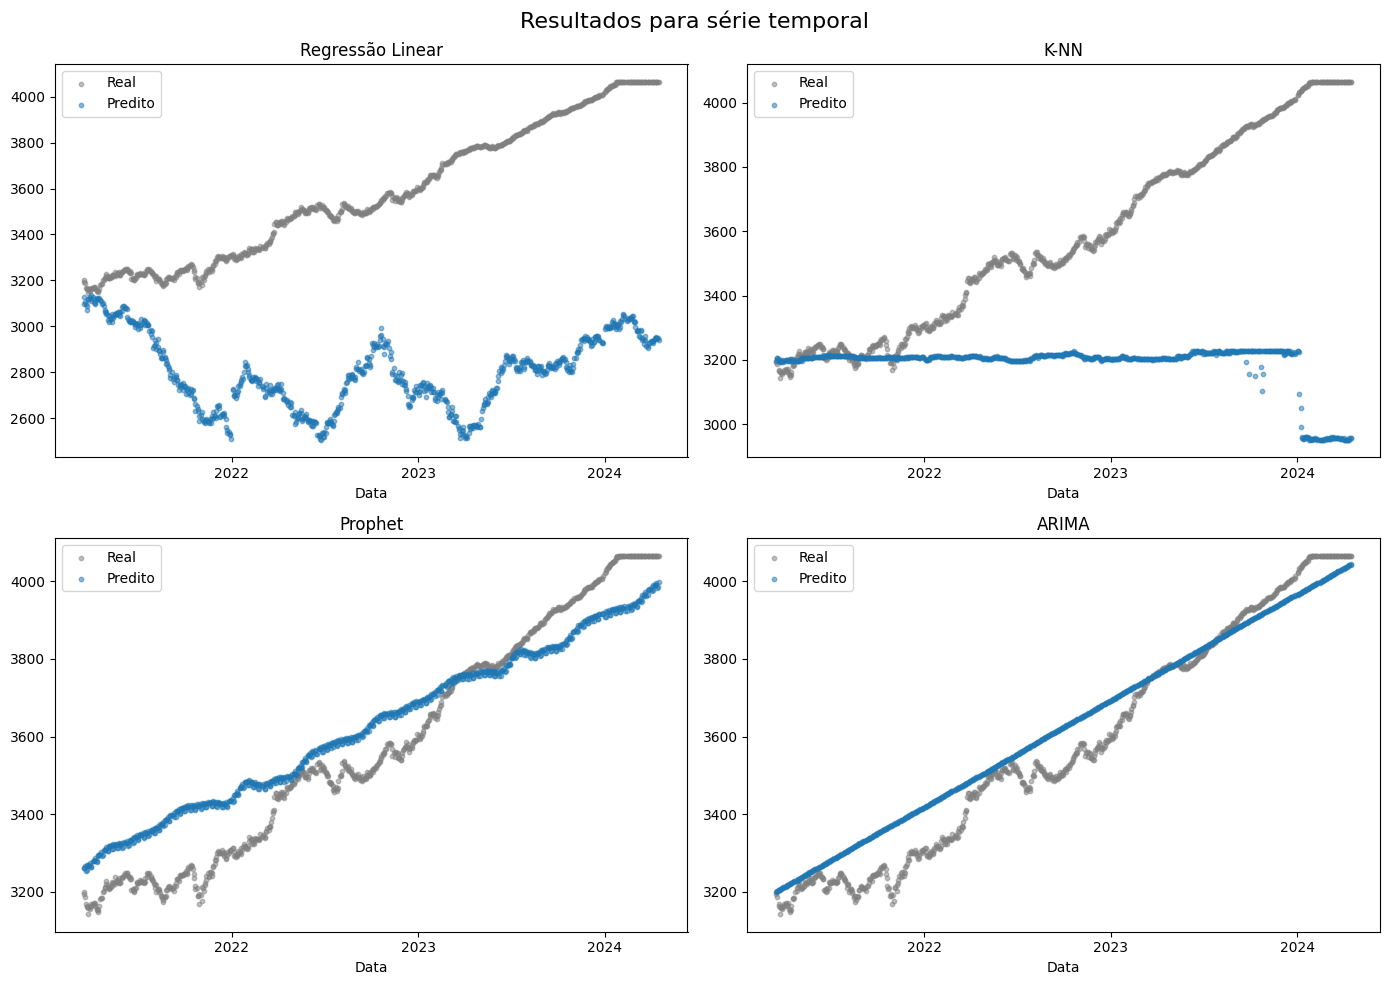

In [155]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(14, 10), sharex=False)
fig.suptitle('Resultados para série temporal', fontsize=16)
axes = axes.flatten()

for ax, (key, predicted) in zip(axes, results.items()):
    ax.scatter(ts_y_test.index, ts_y_test, label='Real', color='grey', alpha=0.5, s=10)
    ax.scatter(ts_y_test.index, predicted, label='Predito', alpha=0.5, s=10)
    ax.legend()
    ax.set_title(f'{key}')
    ax.set_xlabel('Data')

    ax.xaxis.set_major_locator(mdates.YearLocator())
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))

plt.tight_layout()
plt.show()

In [156]:
ts_res_df = pd.DataFrame(create_table_data(ts_y_test, results), columns=get_table_colums())

gt = (
    GT(ts_res_df)
    .tab_header("Resultados considerando séries temporais")
    .opt_all_caps()
    .opt_vertical_padding(scale=1.5)
    .opt_horizontal_padding(scale=3)
    .fmt_number(columns=["MAE", "MSE", "RMSE"], decimals=1)
    .fmt_number(columns="R²", decimals=4)
    .data_color(
        columns=["MSE"],
        palette=["rebeccapurple", "orange"],
        domain=[5500, 710_000],
        na_color="white"
    )
    .data_color(
        columns=["MAE", "RMSE"],
        palette=["rebeccapurple", "orange"],
        domain=[60, 841],
        na_color="white"
    )
    .data_color(
        columns=["R²"],
        palette=["rebeccapurple", "orange"],
        domain=[1, -7.5],
        na_color="white"
    )
)

gt

GT(_tbl_data=             Modelo        R²            MSE         MAE        RMSE
0  Regressão Linear -7.414941  707195.012412  778.427663  840.948876
1              K-NN -2.129125  262972.909658  394.953157  512.808843
2           Prophet  0.867101   11168.843945   92.771726  105.682751
3             ARIMA  0.932452    5676.753861   61.677317   75.344236, _body=<great_tables._gt_data.Body object at 0x00000219CEC52D20>, _boxhead=Boxhead([ColInfo(var='Modelo', type=<ColInfoTypeEnum.default: 1>, column_label='Modelo', column_align='left', column_width=None), ColInfo(var='R²', type=<ColInfoTypeEnum.default: 1>, column_label='R²', column_align='right', column_width=None), ColInfo(var='MSE', type=<ColInfoTypeEnum.default: 1>, column_label='MSE', column_align='right', column_width=None), ColInfo(var='MAE', type=<ColInfoTypeEnum.default: 1>, column_label='MAE', column_align='right', column_width=None), ColInfo(var='RMSE', type=<ColInfoTypeEnum.default: 1>, column_label='RMSE', column_align='right', column_width=None)]), _stub=Stub([RowInfo(rownum_i=0, group_id=None, rowname=None, group_label=None, built=False), RowInfo(rownum_i=1, group_id=None, rowname=None, group_label=None, built=False), RowInfo(rownum_i=2, group_id=None, rowname=None, group_label=None, built=False), RowInfo(rownum_i=3, group_id=None, rowname=None, group_label=None, built=False)]), _row_groups=[], _group_rows=GroupRows([]), _spanners=Spanners([]), _heading=Heading(title='Resultados considerando séries temporais', subtitle=None, preheader=None), _stubhead=None, _source_notes=[], _footnotes=[], _styles=[StyleInfo(locname='data', locnum=5, grpname=None, colname='MSE', rownum=0, colnum=None, styles=[CellStyleText(color='#000000', font=None, size=None, align=None, v_align=None, style=None, weight=None, stretch=None, decorate=None, transform=None, whitespace=None), CellStyleFill(color='#fea501')]), StyleInfo(locname='data', locnum=5, grpname=None, colname='MSE', rownum=1, colnum=None, styles=[CellStyleText(color='#FFFFFF', font=None, size=None, align=None, v_align=None, style=None, weight=None, stretch=None, decorate=None, transform=None, whitespace=None), CellStyleFill(color='#9e5d61')]), StyleInfo(locname='data', locnum=5, grpname=None, colname='MSE', rownum=2, colnum=None, styles=[CellStyleText(color='#FFFFFF', font=None, size=None, align=None, v_align=None, style=None, weight=None, stretch=None, decorate=None, transform=None, whitespace=None), CellStyleFill(color='#673498')]), StyleInfo(locname='data', locnum=5, grpname=None, colname='MSE', rownum=3, colnum=None, styles=[CellStyleText(color='#FFFFFF', font=None, size=None, align=None, v_align=None, style=None, weight=None, stretch=None, decorate=None, transform=None, whitespace=None), CellStyleFill(color='#663399')]), StyleInfo(locname='data', locnum=5, grpname=None, colname='MAE', rownum=0, colnum=None, styles=[CellStyleText(color='#000000', font=None, size=None, align=None, v_align=None, style=None, weight=None, stretch=None, decorate=None, transform=None, whitespace=None), CellStyleFill(color='#f39c0c')]), StyleInfo(locname='data', locnum=5, grpname=None, colname='MAE', rownum=1, colnum=None, styles=[CellStyleText(color='#000000', font=None, size=None, align=None, v_align=None, style=None, weight=None, stretch=None, decorate=None, transform=None, whitespace=None), CellStyleFill(color='#a86457')]), StyleInfo(locname='data', locnum=5, grpname=None, colname='MAE', rownum=2, colnum=None, styles=[CellStyleText(color='#FFFFFF', font=None, size=None, align=None, v_align=None, style=None, weight=None, stretch=None, decorate=None, transform=None, whitespace=None), CellStyleFill(color='#6c3893')]), StyleInfo(locname='data', locnum=5, grpname=None, colname='MAE', rownum=3, colnum=None, styles=[CellStyleText(color='#FFFFFF', font=None, size=None, align=None, v_align=None, style=None, weight=None, stretch=None, decorate=None, transform=None, whitespace=None), CellStyleFill(color='#663399')]), StyleInfo(locname='data', locnum=

Pelo que pudemos observar, regressão linear e K-NN não foram bons modelos. Ademais, o modelo ARIMA obteve um desempenho superior em relação ao Prophet, tendo em vista que seu erro médio foi cerca de duas vezes menor, e seu R² foi consideravelmente maior.

## Referências p/ Dados Financeiros

- [Biblioteca Python BCB](https://github.com/wilsonfreitas/python-bcb)

- [Python BCB](https://wilsonfreitas.github.io/python-bcb/sgs.html)

- [Nasdaq Data Link](https://github.com/Nasdaq/data-link-python/tree/main)

- [Yahoo Finance](https://www.geeksforgeeks.org/get-financial-data-from-yahoo-finance-with-python/)

Visualização

- [Great Tables](https://posit-dev.github.io/great-tables/articles/intro.html)